In [1]:
!git clone https://github.com/haotian-liu/LLaVA.git
%cd LLaVA
!pip install -e .
!pip install transformers accelerate timm xformers opencv-python
!git lfs install
!git clone https://huggingface.co/liuhaotian/llava-v1.5-7b checkpoints/llava-v1.5-7b


Cloning into 'LLaVA'...
remote: Enumerating objects: 2297, done.
remote: Total 2297 (delta 0), reused 0 (delta 0), pack-reused 2297 (from 1)
Receiving objects: 100% (2297/2297), 13.71 MiB | 21.11 MiB/s, done.
Resolving deltas: 100% (1404/1404), done.
/content/LLaVA
Obtaining file:///content/LLaVA
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.7/137.7 kB 10.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.7/

INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.4/43.4 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 766.7/766.7 MB 78.6 MB/s eta 0:00:01^C
^C
Cloning into 'checkpoints/llava-v1.5-7b'...
^C


In [ ]:
!unzip кластеры.zip

In [13]:
prompt = '''
Есть такие кластеры: голосование, логинка, инвестиции, лотерея. Кластер может быть только один!

Если на картинке экран с двумя фотографиями, на которых изображены девушки или женщины или маленькие дети или девочки с собаками, то это голосование.
Если на картинке есть два изображения: один изображает медведя, а другой - женщину, то это голосование.
Если на картинке есть страницу с сайта, на которой представлены два аватара, или профили, и подписки и один аватар находится на левом краю страницы, а другой на правом, то это голосование.
Если на картинке есть два изображения людей, которые могут быть изображениями двух друзей, то это голосование.

Выведи для каждой картинки кластер.
'''

In [17]:
import os
from collections import defaultdict
import glob

uploaded = {}
for path in glob.glob("кластеры/голосование/*.png"):
    uploaded[path] = None

results = {}
labels = ['логинка', 'инвестиции', 'лотерея', 'голосование']
y_true = []
y_pred = []

class_stats = defaultdict(lambda: {"correct": 0, "total": 0})

for image_path in uploaded.keys():
    print(f"Обрабатывается: {image_path}")

    !python3 -m llava.eval.run_llava \
      --model-path liuhaotian/llava-v1.5-7b \
      --image-file "$image_path" \
      --query "$prompt" \
      --temperature 0.7 \
      --top_p 1.0 \
      --num_beams 1 \
      --max_new_tokens 100


    with open("temp_output.txt", "r") as f:
        lines = f.readlines()
        if lines:
            last_line = lines[-1].strip()
            results[image_path] = last_line
        else:
            last_line = "нет вывода"
            results[image_path] = last_line

    true_label = os.path.basename(os.path.dirname(image_path))
    y_true.append(true_label)

    predicted_label = None
    for label in labels:
        if label in last_line.lower():
            predicted_label = label
            break
    if predicted_label is None:
        predicted_label = "неизвестно"
    y_pred.append(predicted_label)

    class_stats[true_label]["total"] += 1
    if predicted_label == true_label:
        class_stats[true_label]["correct"] += 1

correct = sum(1 for t, p in zip(y_true, y_pred) if t == p)
total = len(y_true)
accuracy = correct / total if total > 0 else 0

print("\nAccuracy по классу 'голосование':")
loginka_stats = class_stats["голосование"]
if loginka_stats["total"] > 0:
    acc = loginka_stats["correct"] / loginka_stats["total"]
    print(f"голосование: {acc:.2%} ({loginka_stats['correct']}/{loginka_stats['total']})")
else:
    print("голосование: нет изображений")

print("\nОшибки (true → pred):")
for i in range(len(y_true)):
    if y_true[i] != y_pred[i]:
        image_name = list(results.keys())[i]
        print(f"{y_true[i]} --> {y_pred[i]} | {image_name} | output: {results[image_name]}")

Обрабатывается: кластеры/голосование/000047.png
The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
2025-04-09 18:27:41.242156: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744223261.288367    8856 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744223261.303911    8856 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, 

кластеры/голосование/000047.png --> нет вывода


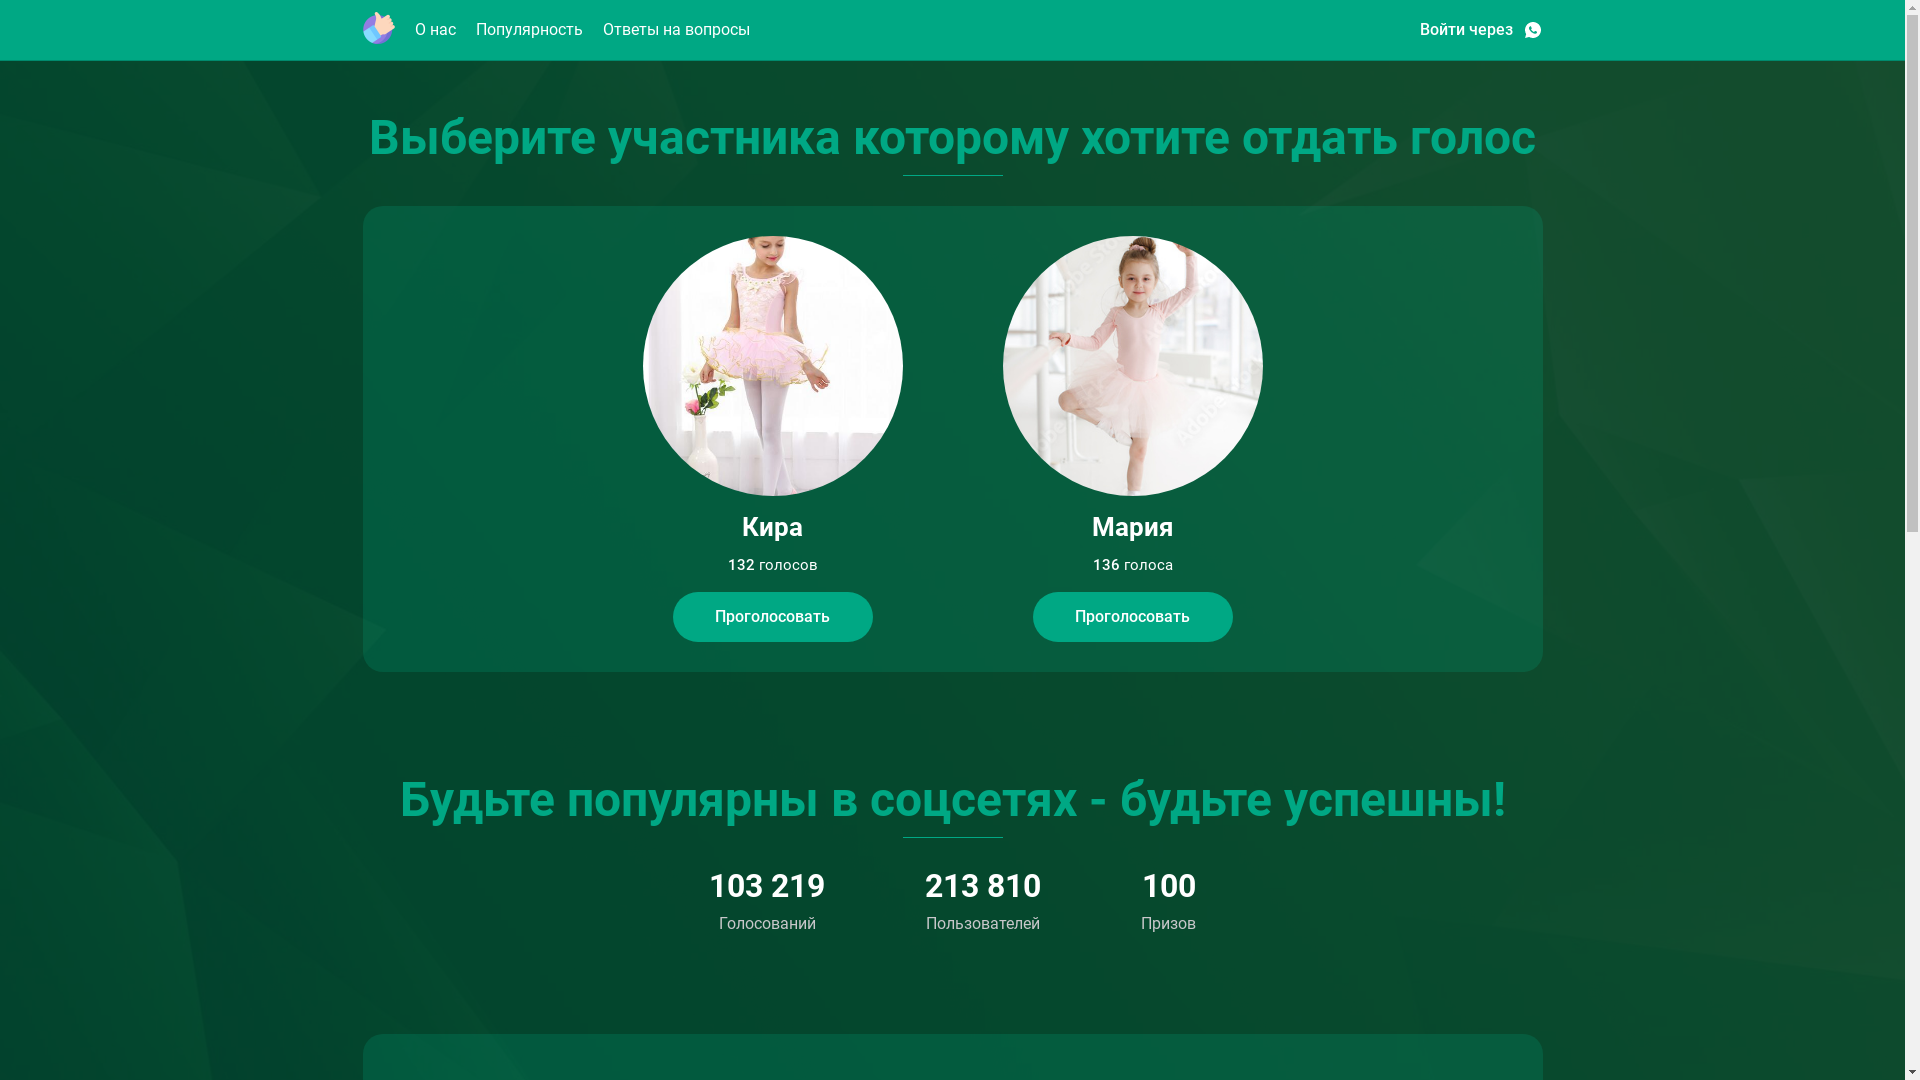

кластеры/голосование/000004.png --> нет вывода


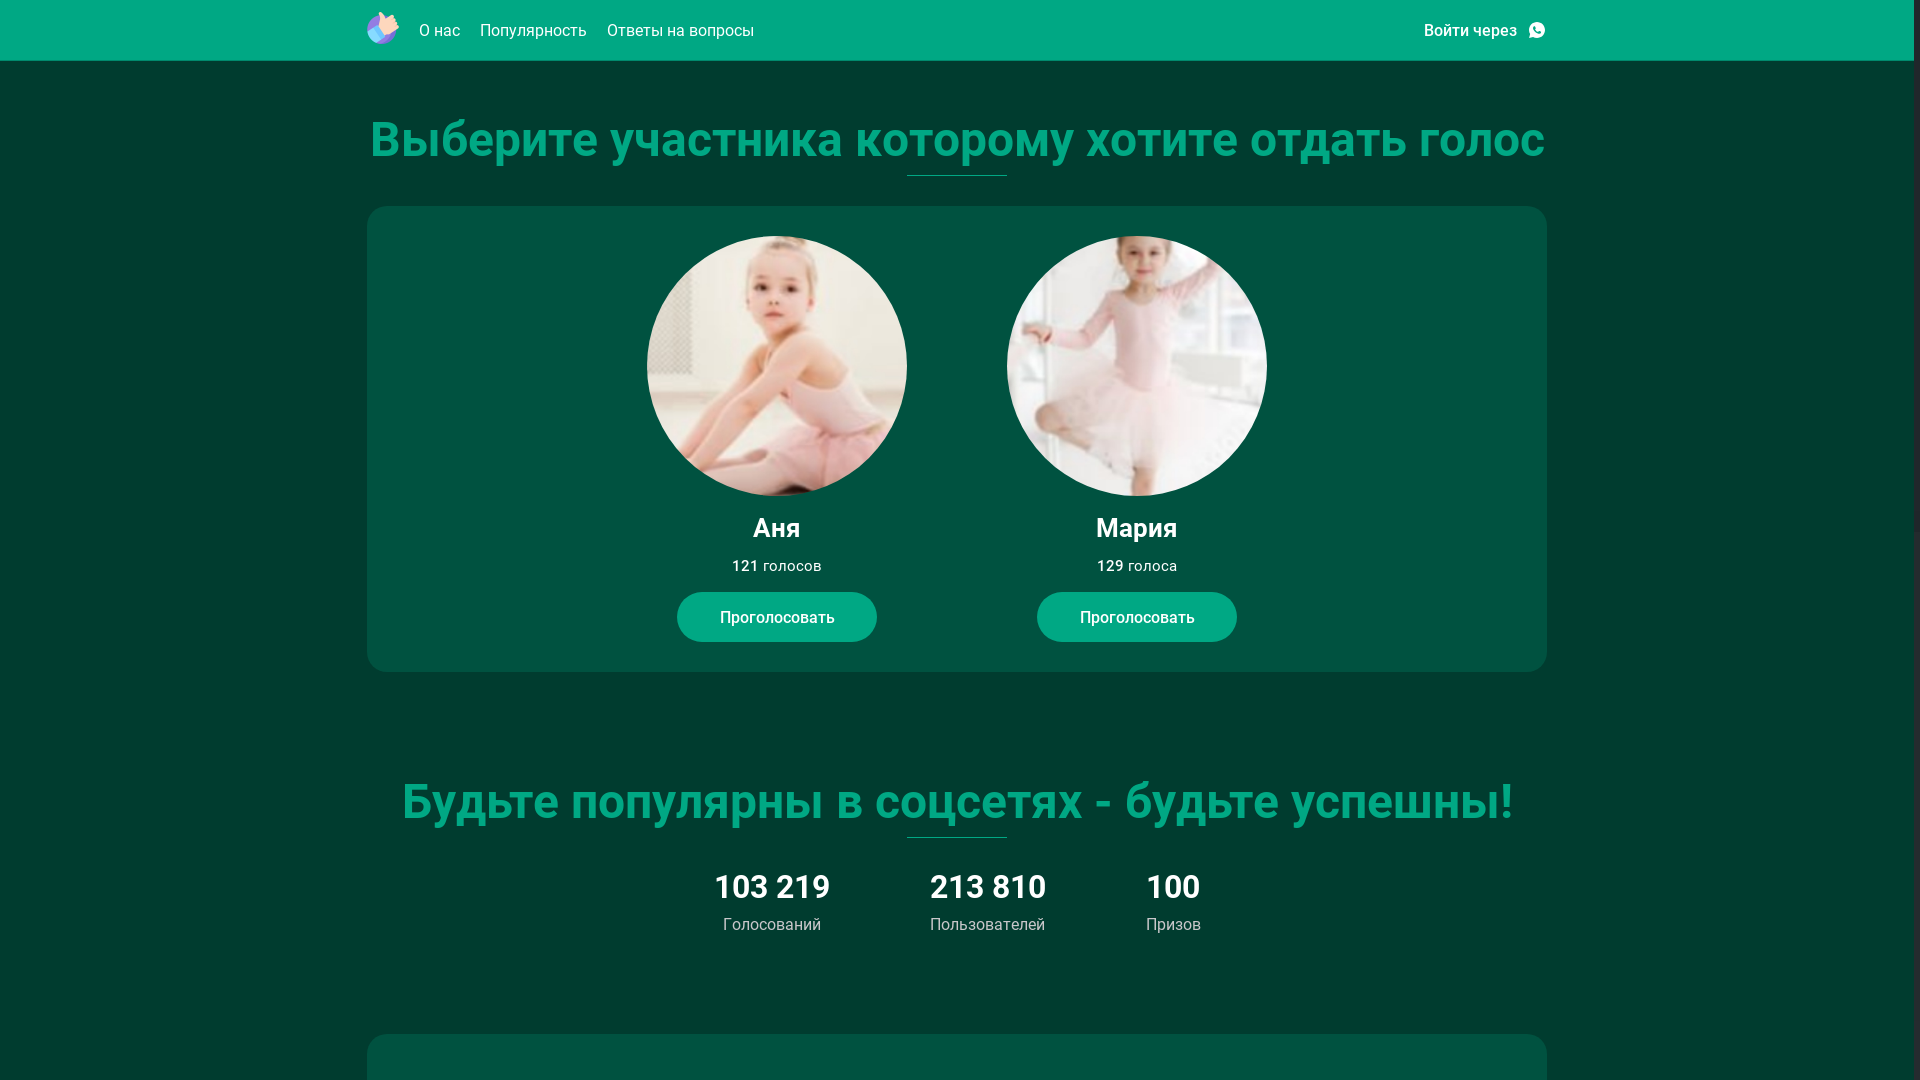

кластеры/голосование/000020.png --> нет вывода


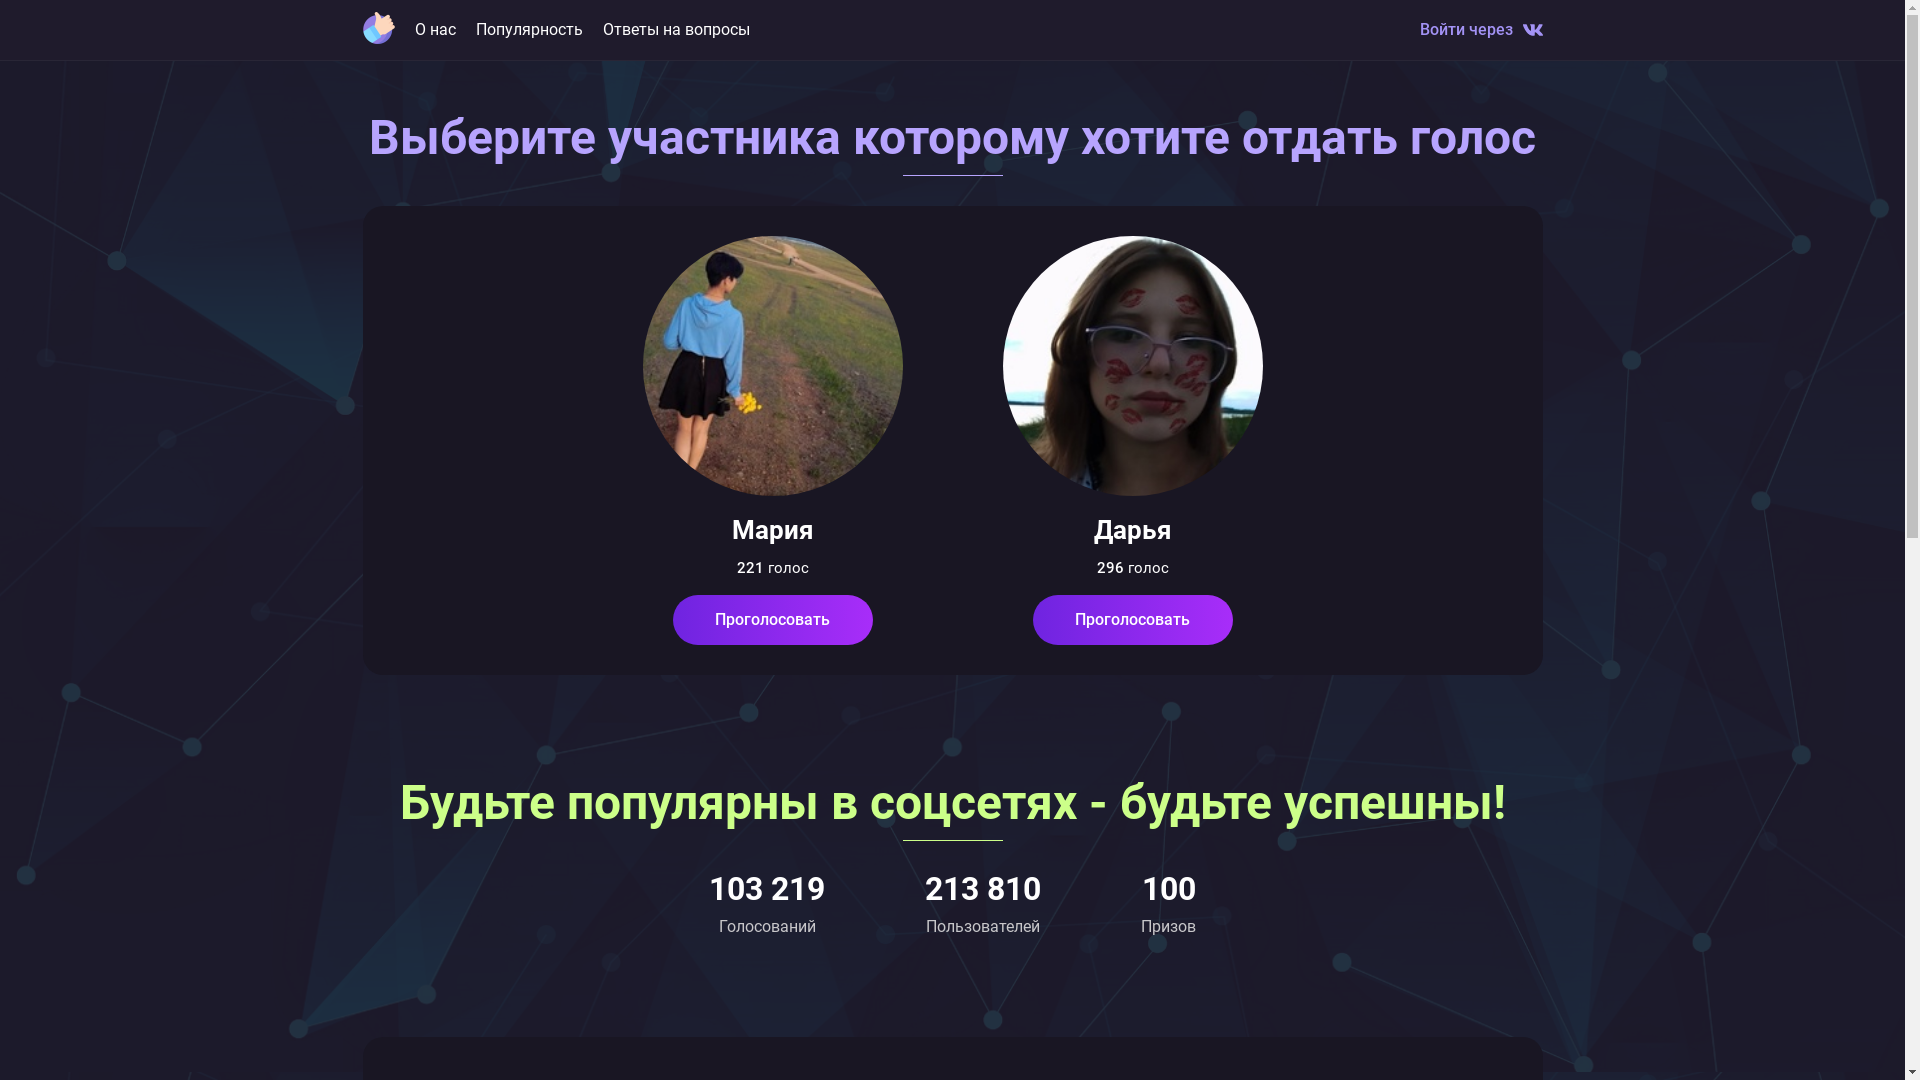

кластеры/голосование/000005.png --> нет вывода


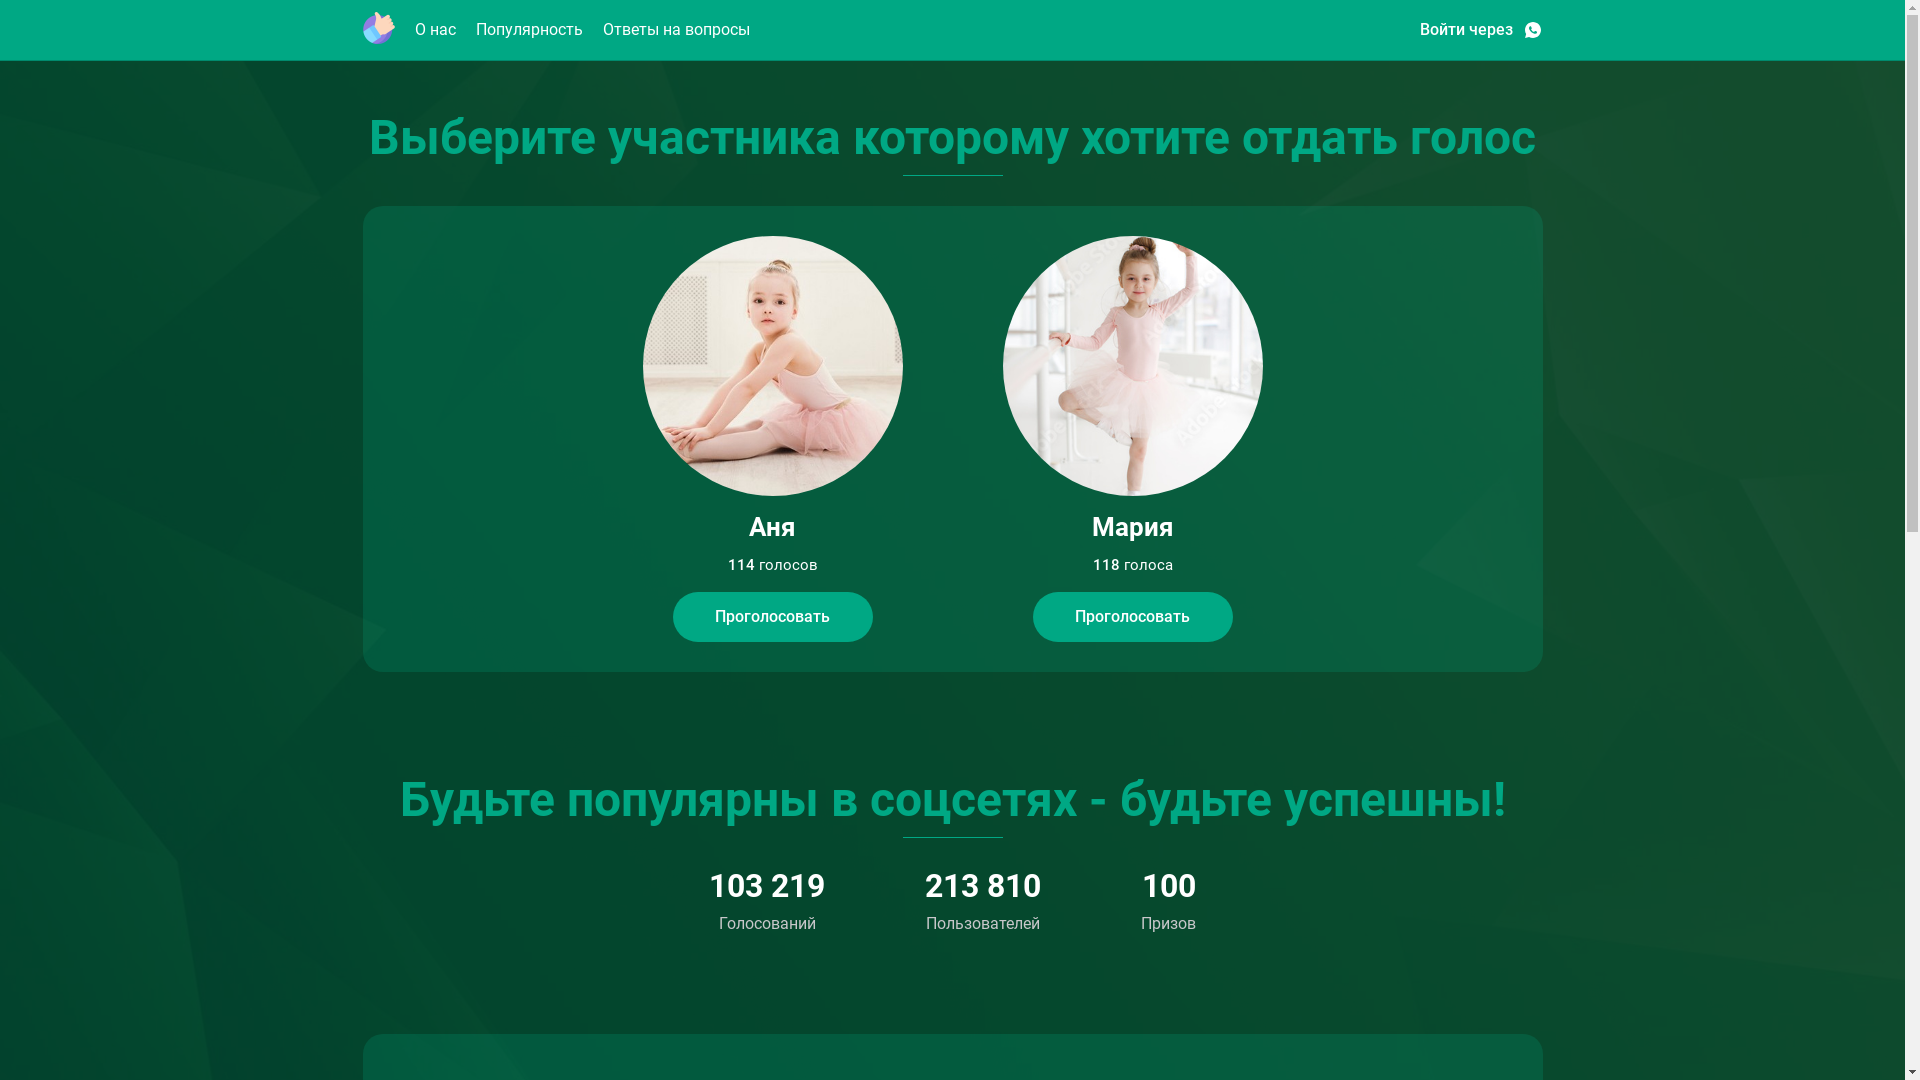

кластеры/голосование/000058.png --> нет вывода


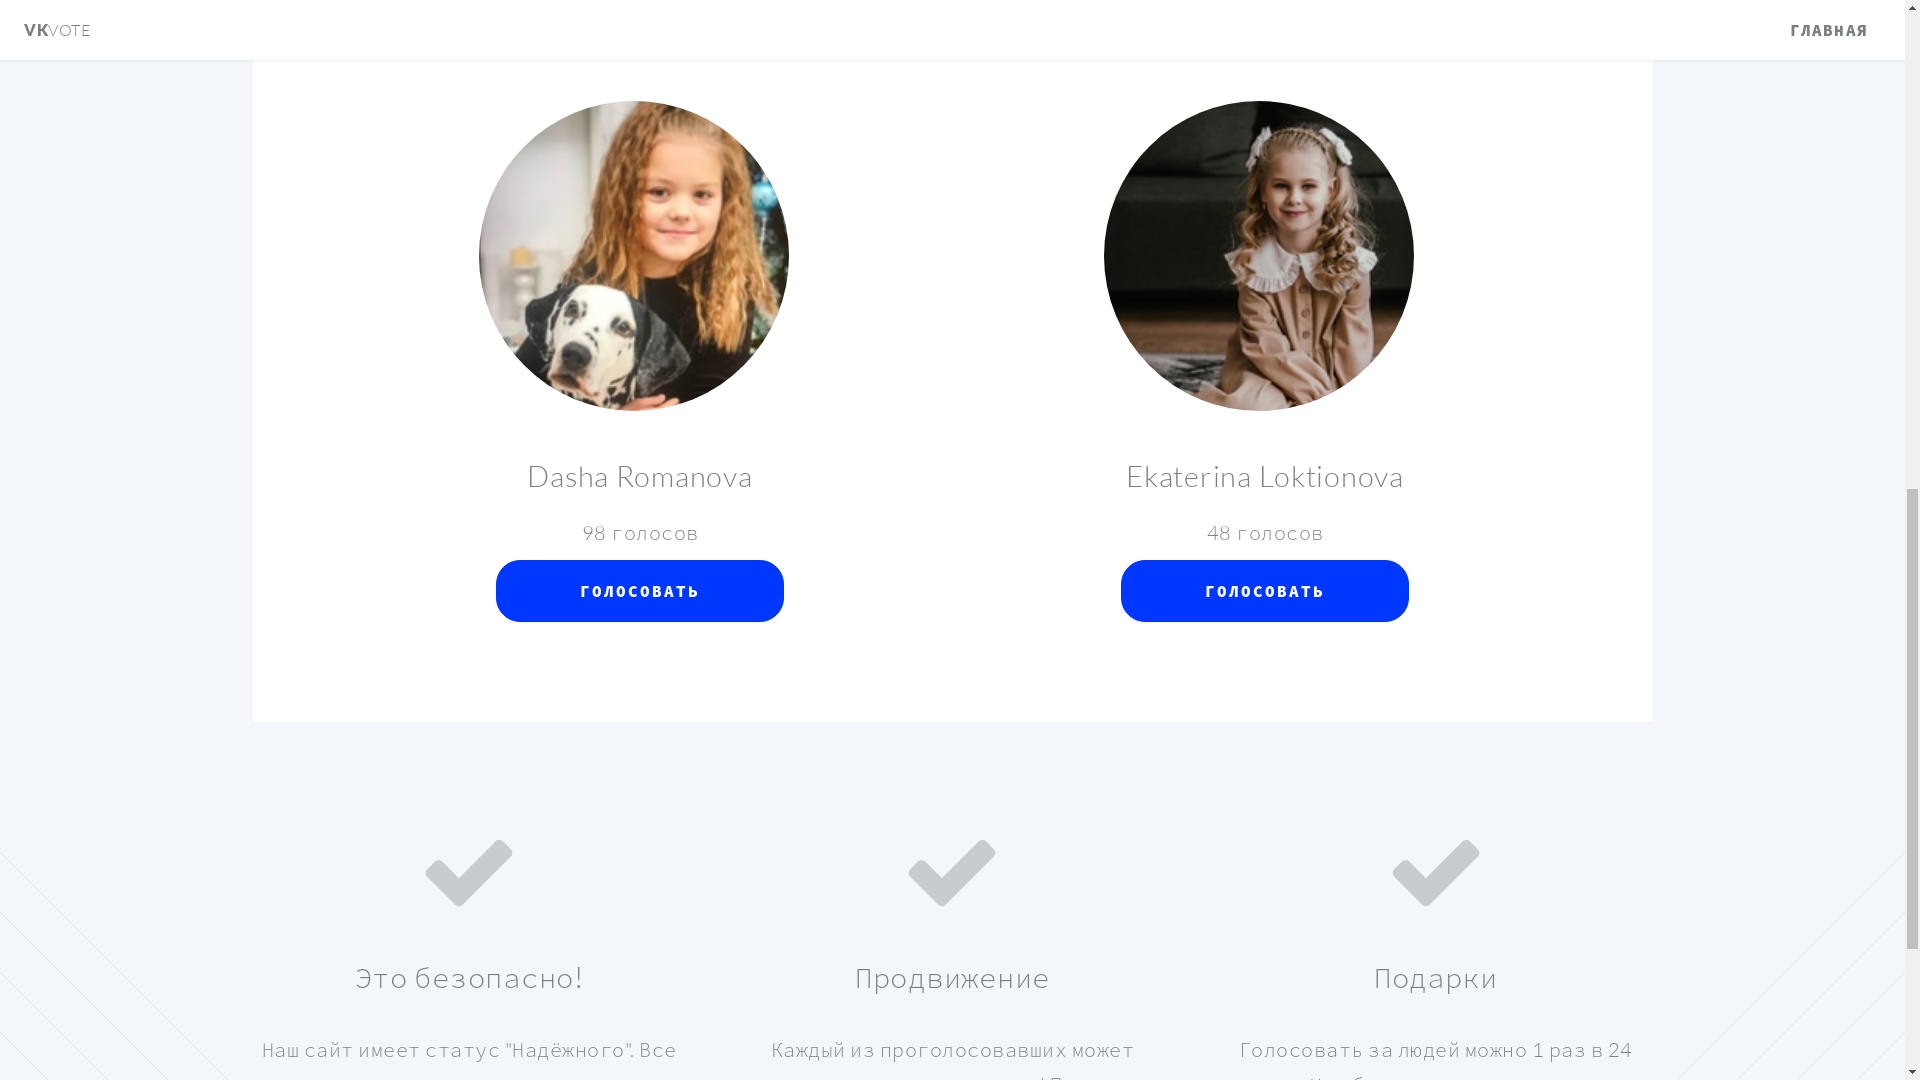

кластеры/голосование/000131.png --> нет вывода


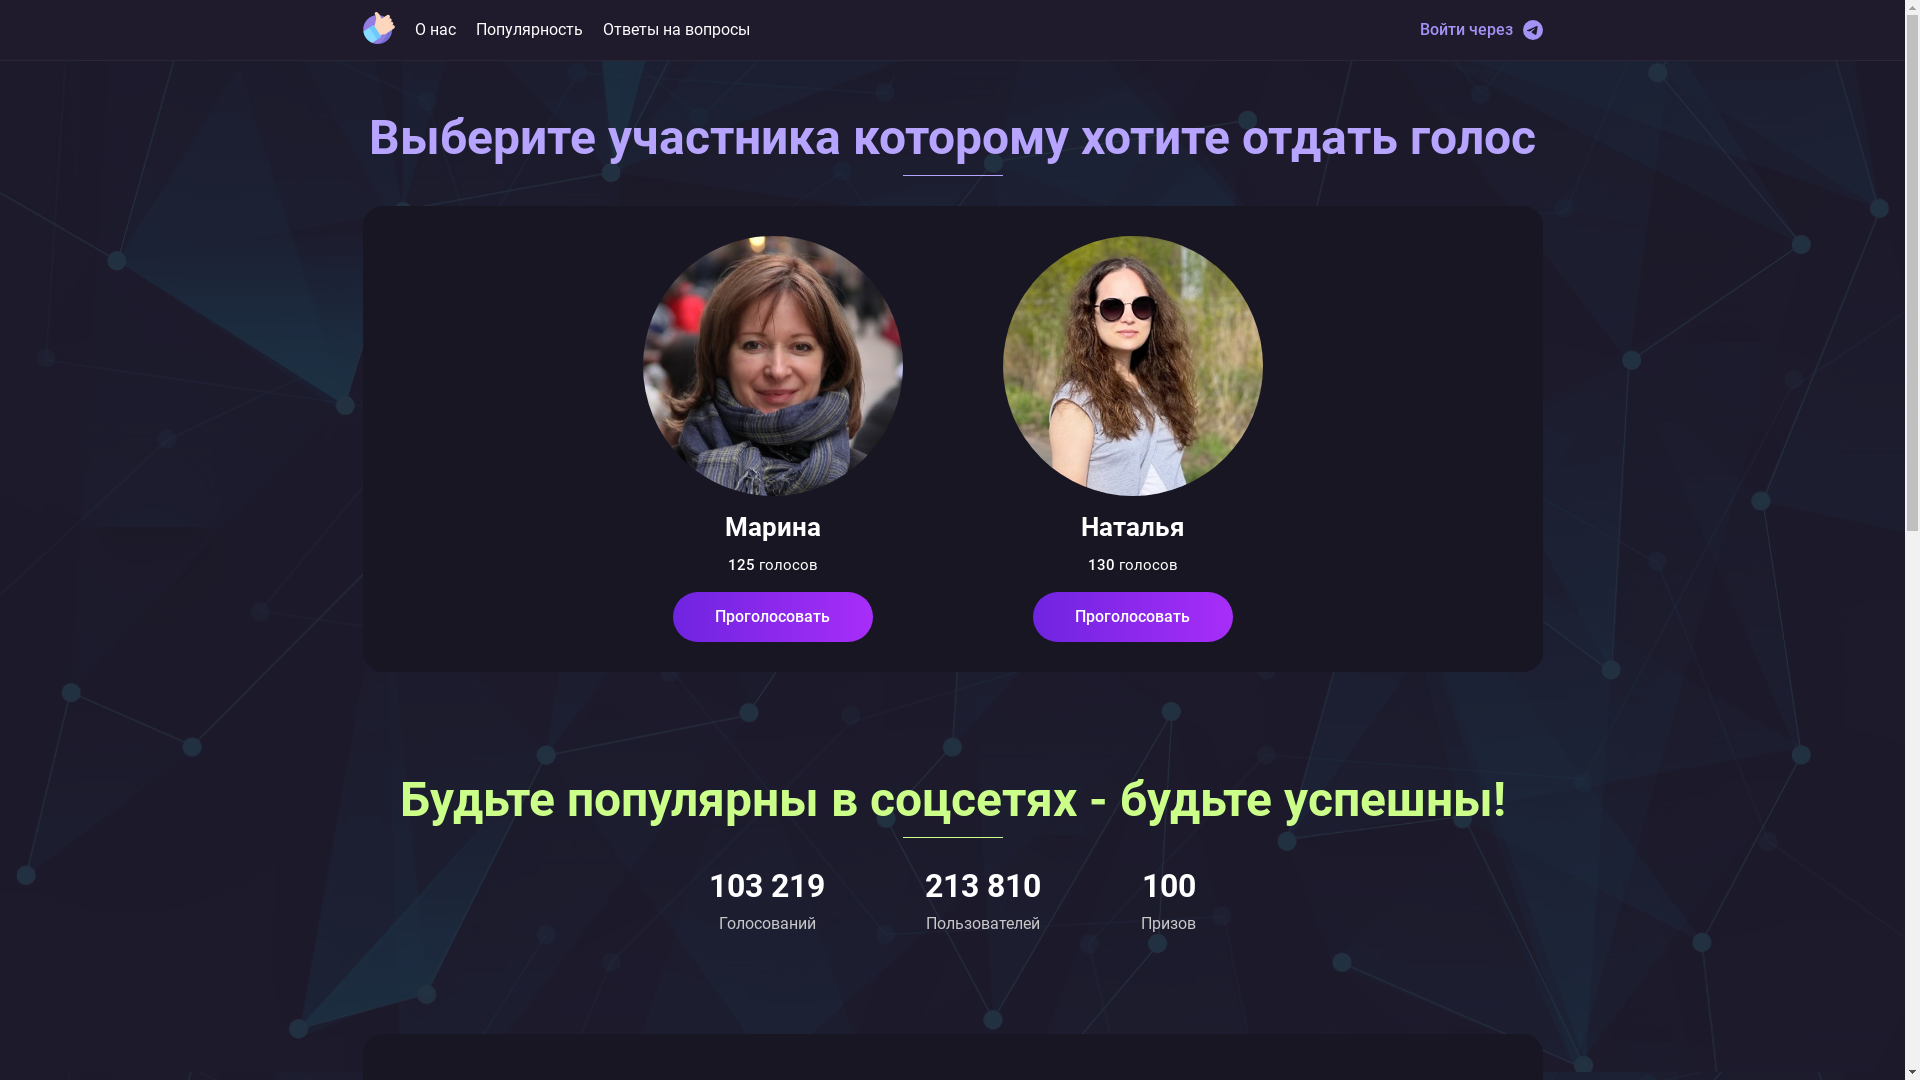

кластеры/голосование/000159.png --> нет вывода


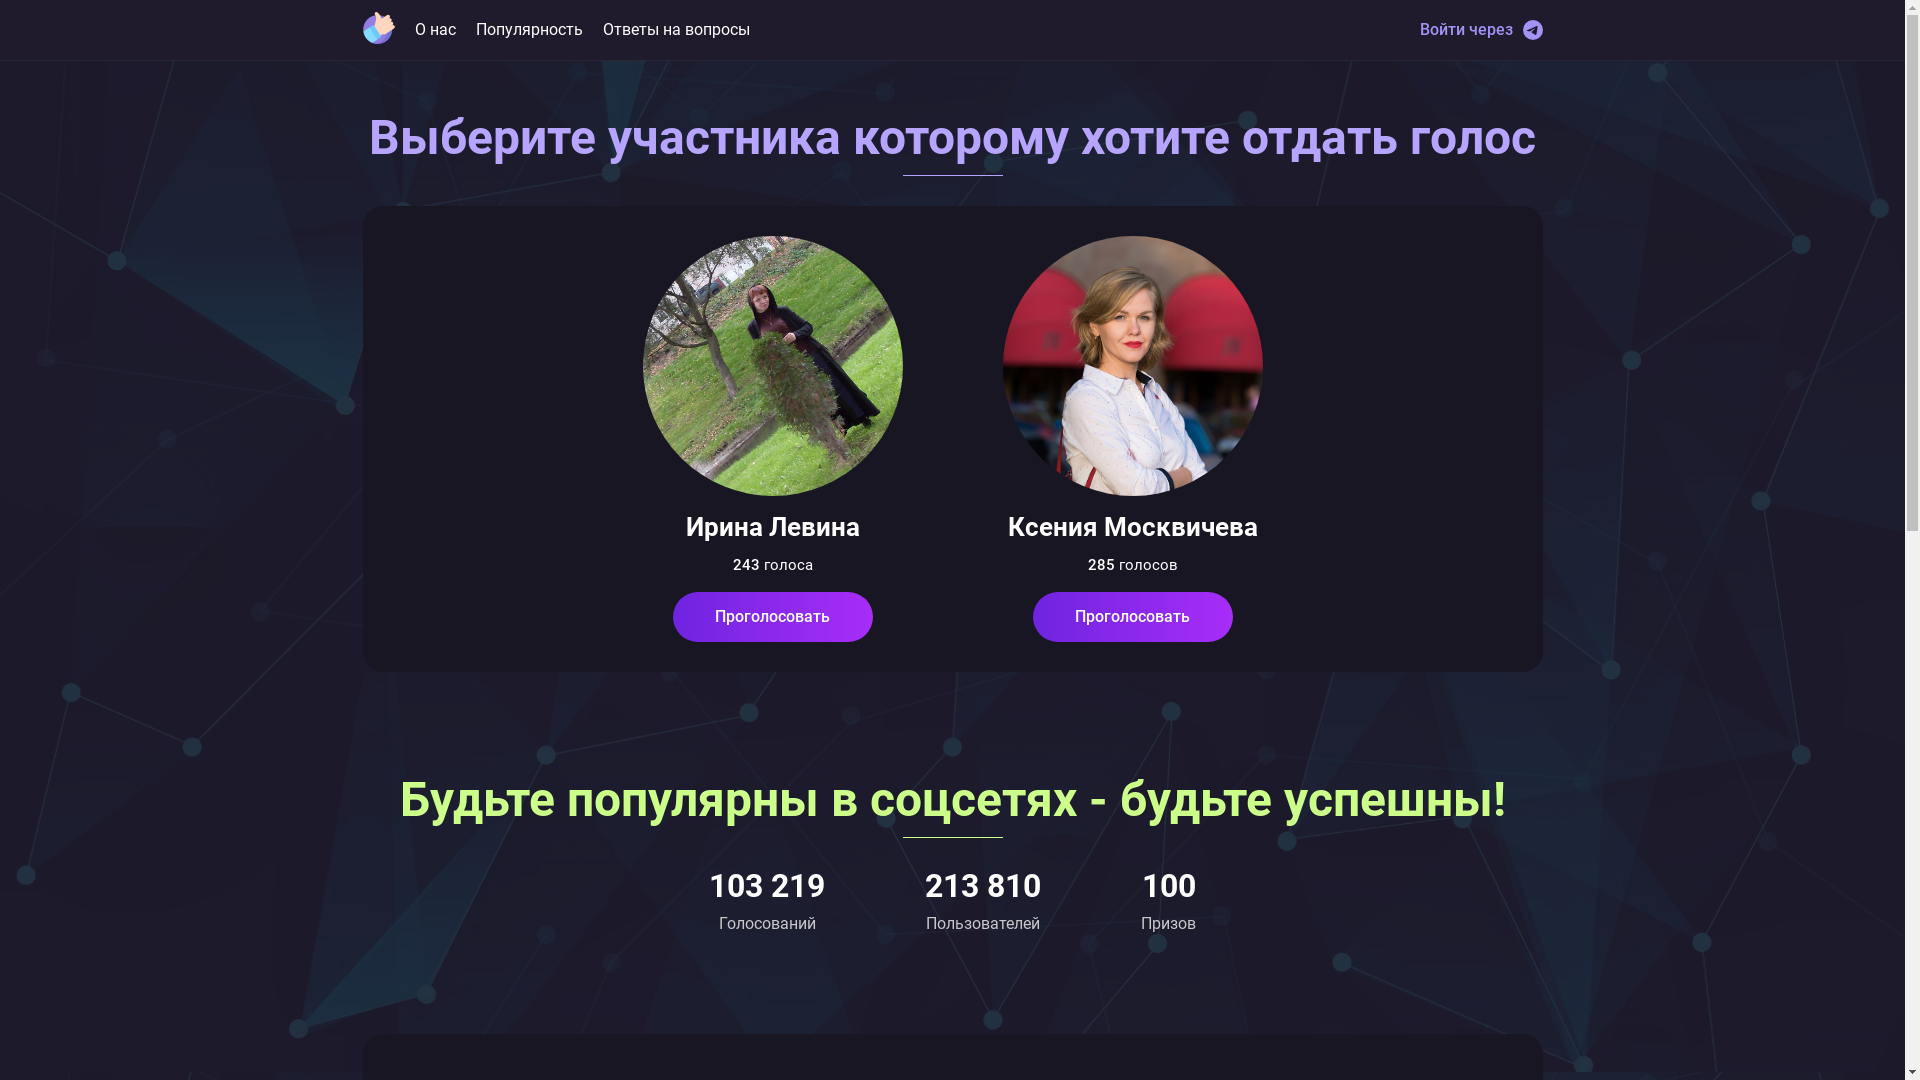

кластеры/голосование/000838.png --> нет вывода


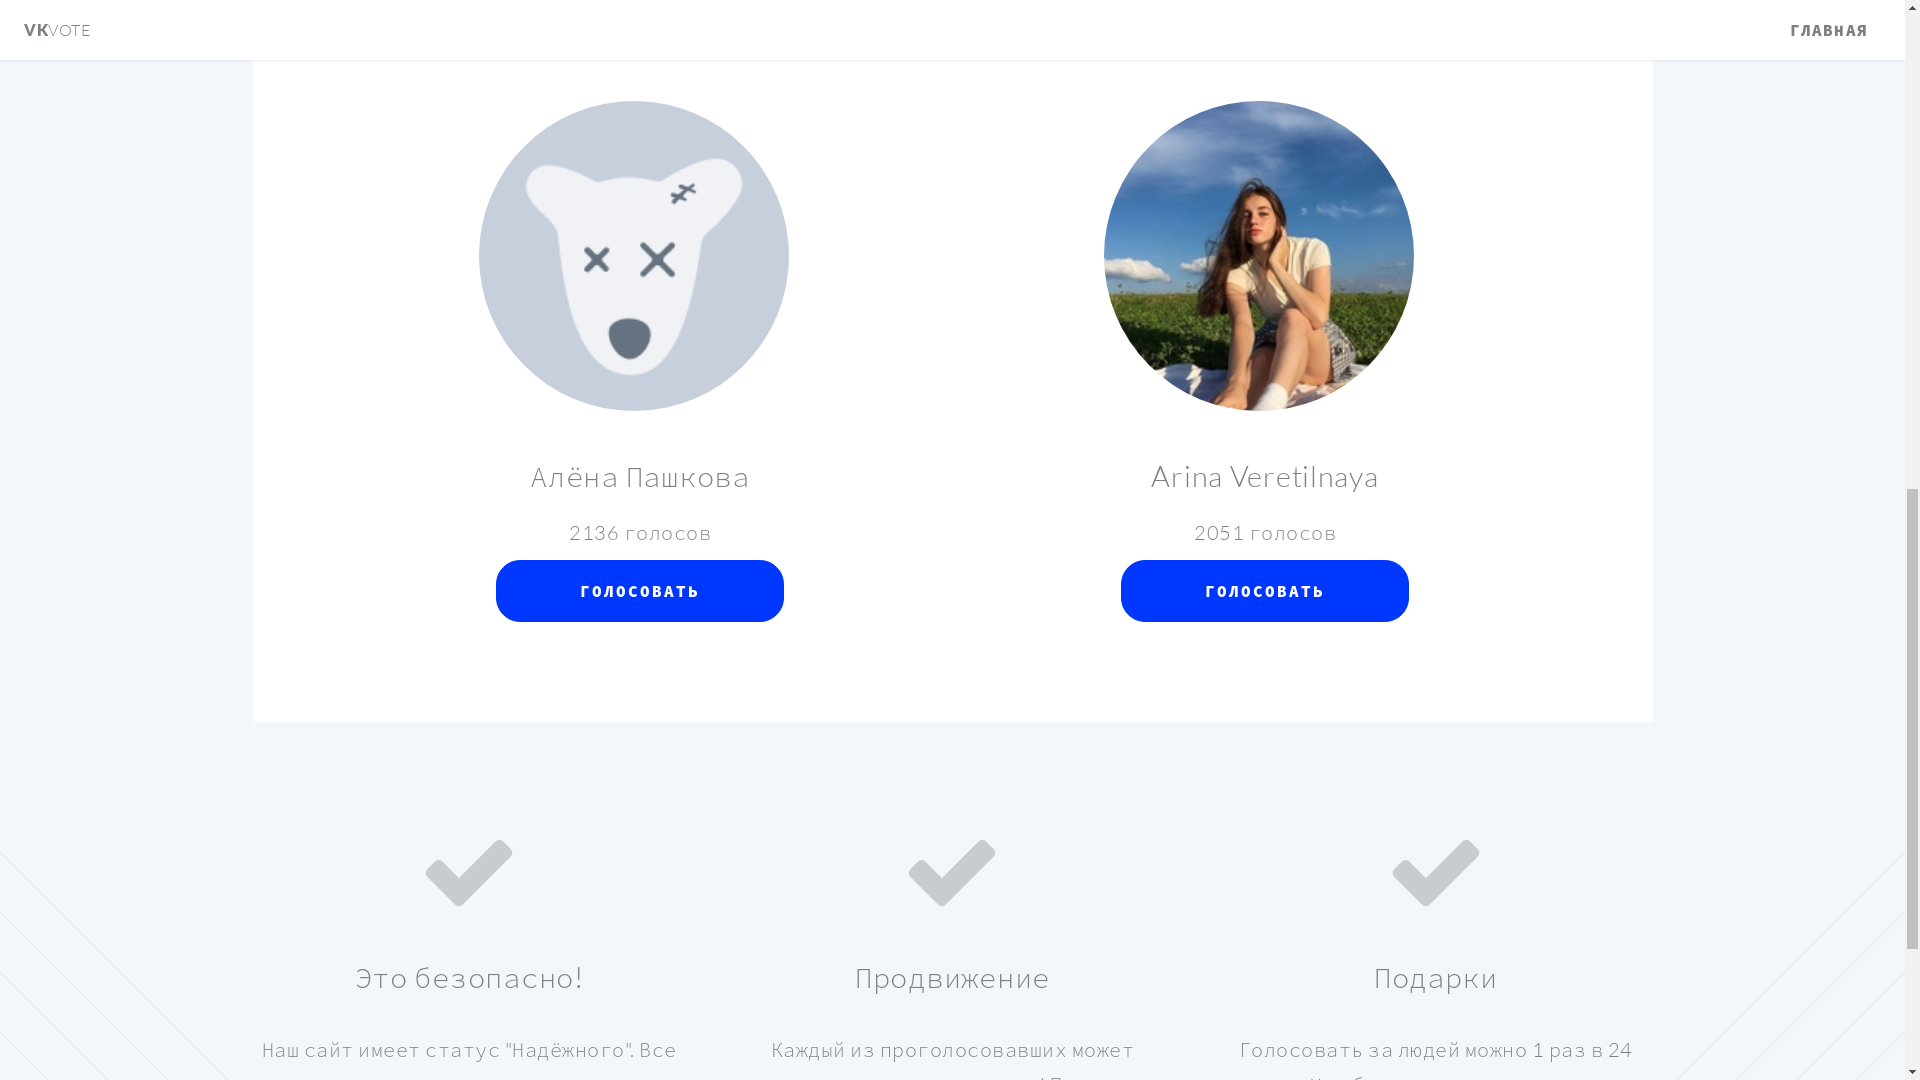

кластеры/голосование/000050.png --> нет вывода


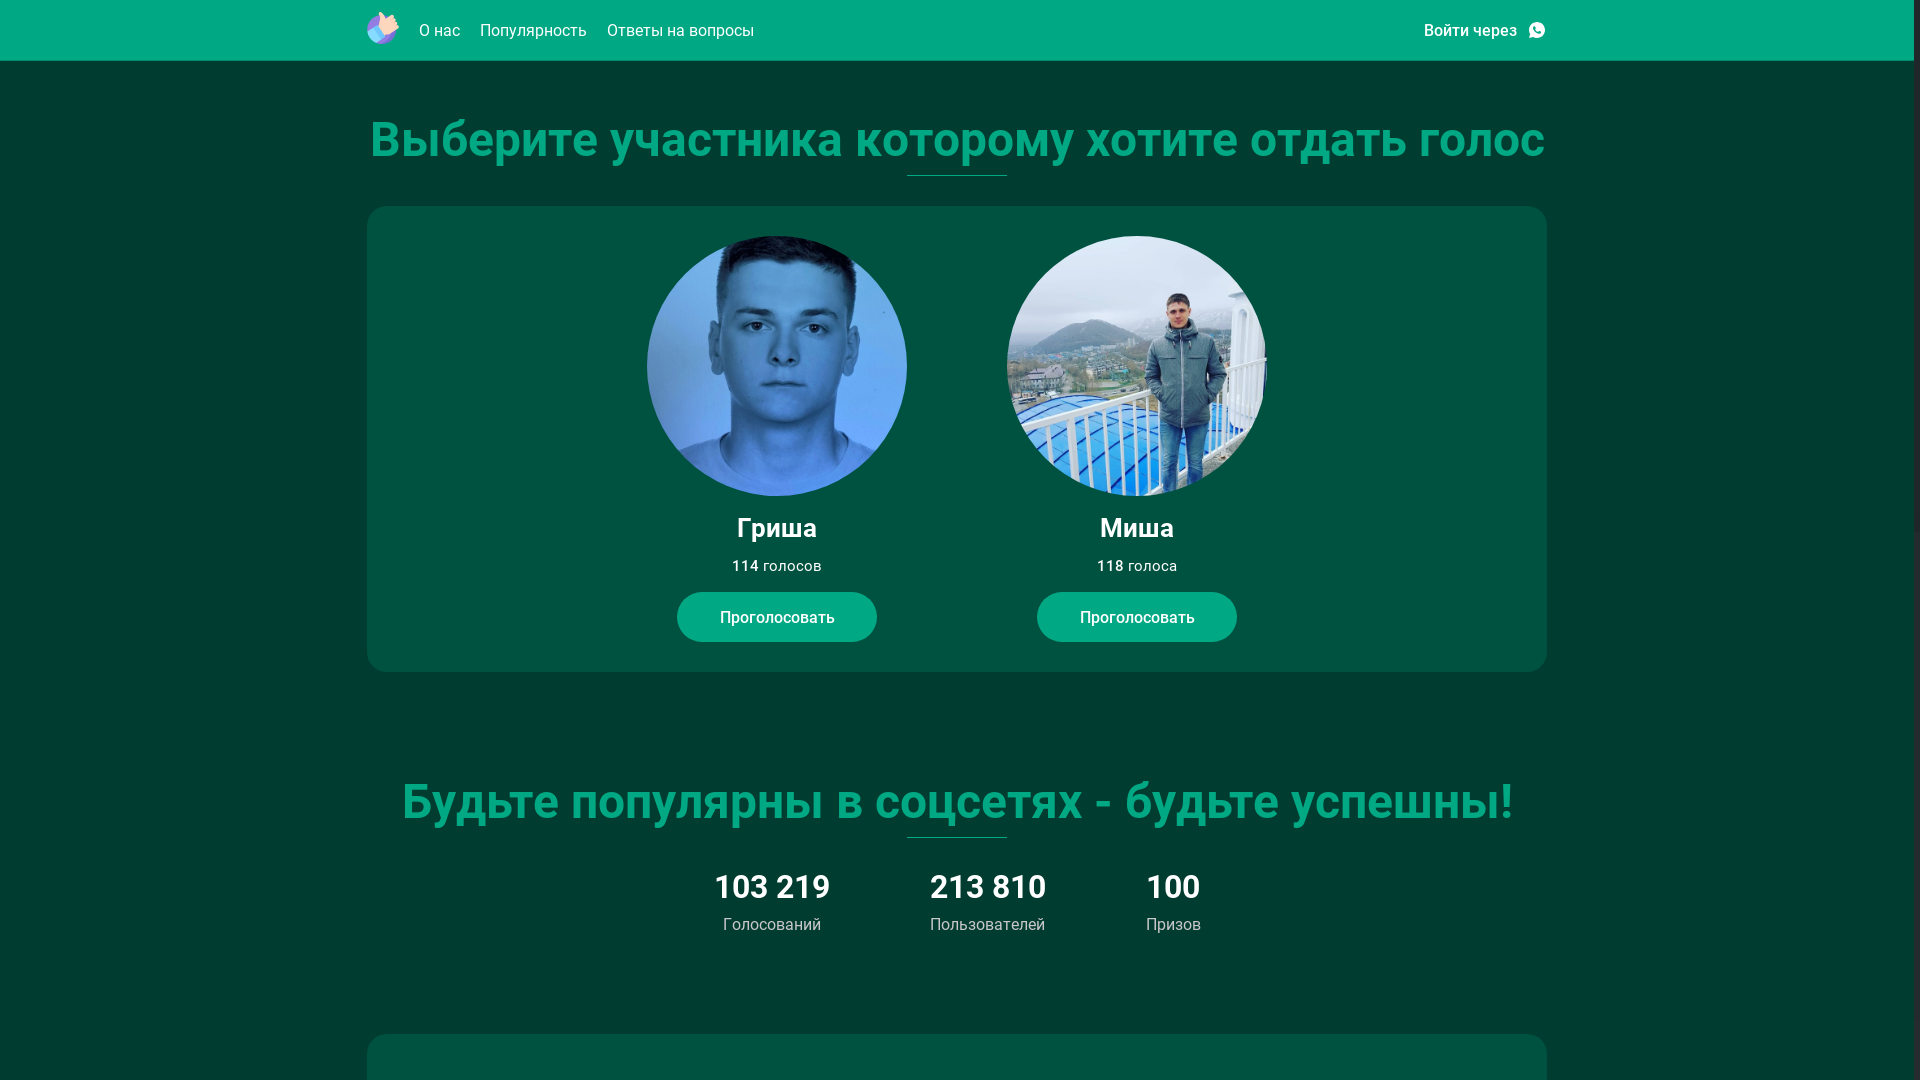

кластеры/голосование/000287.png --> нет вывода


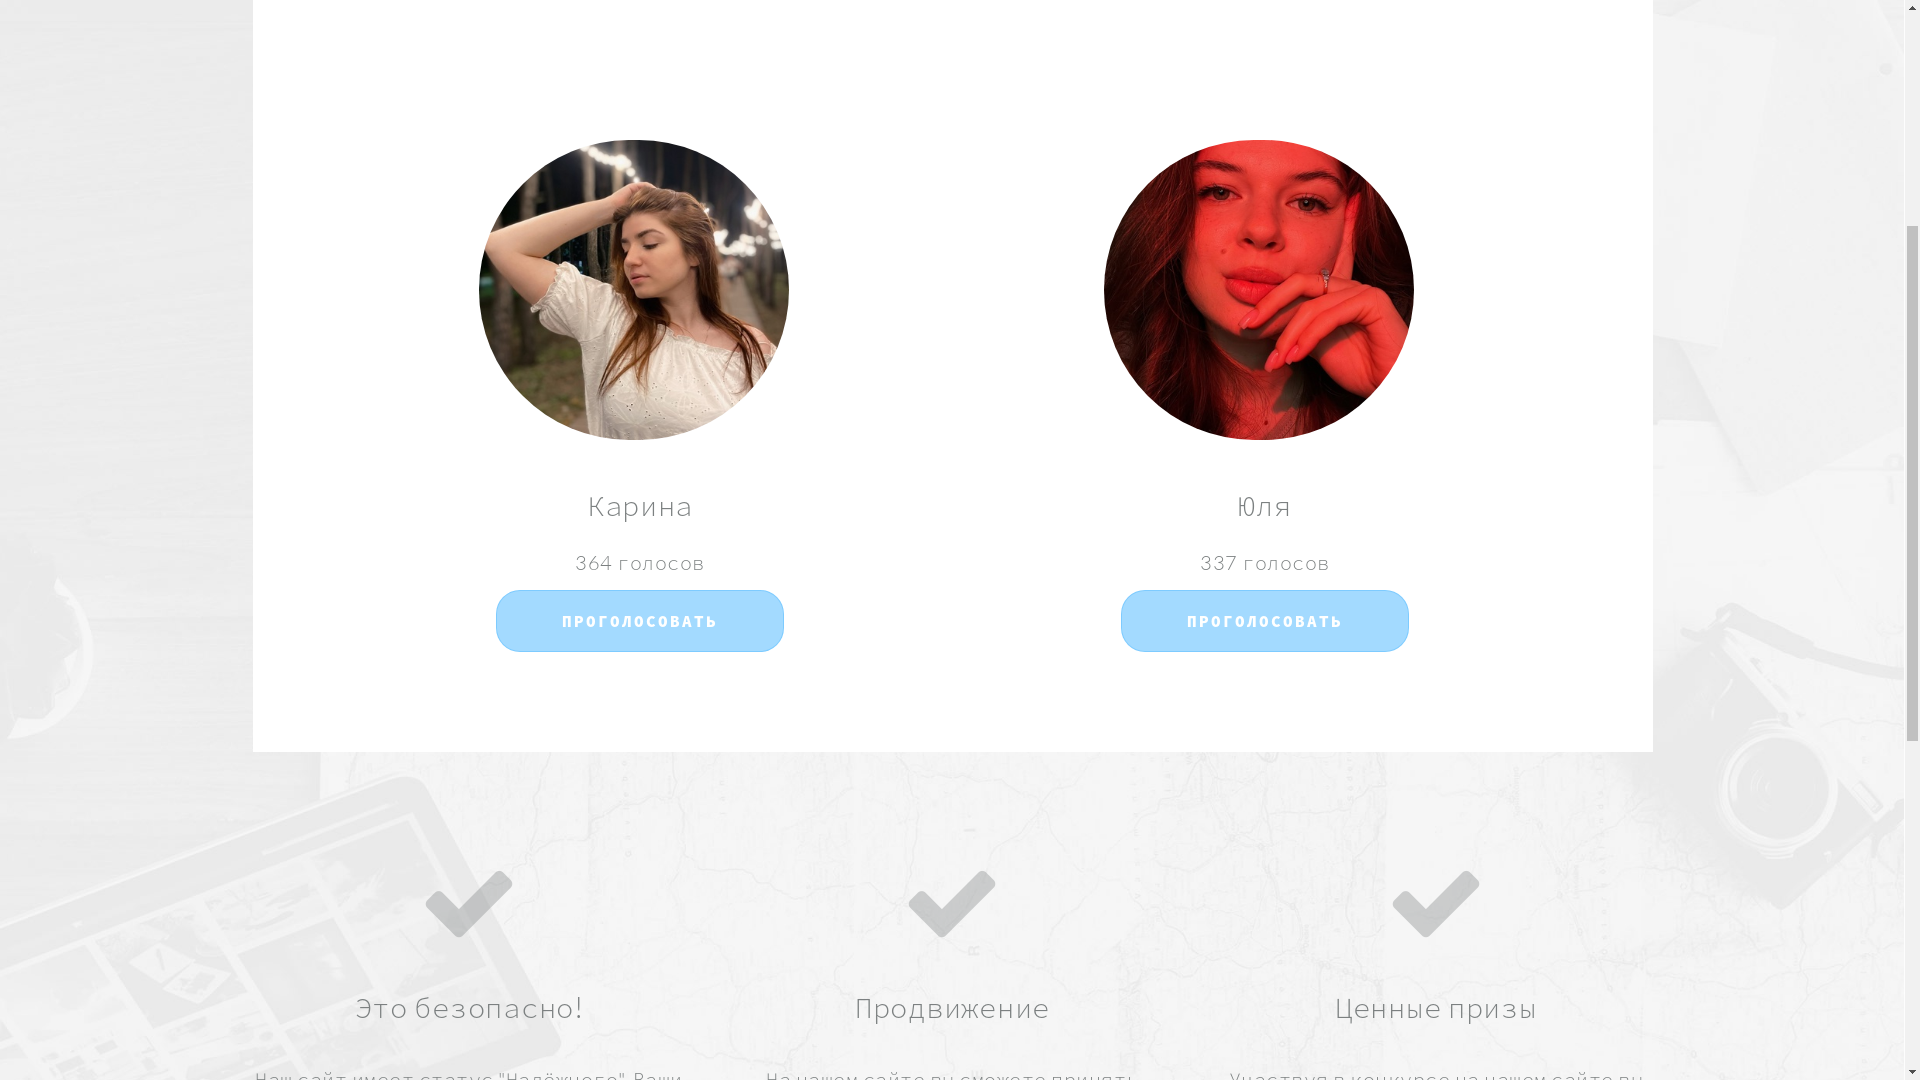

кластеры/голосование/000053.png --> нет вывода


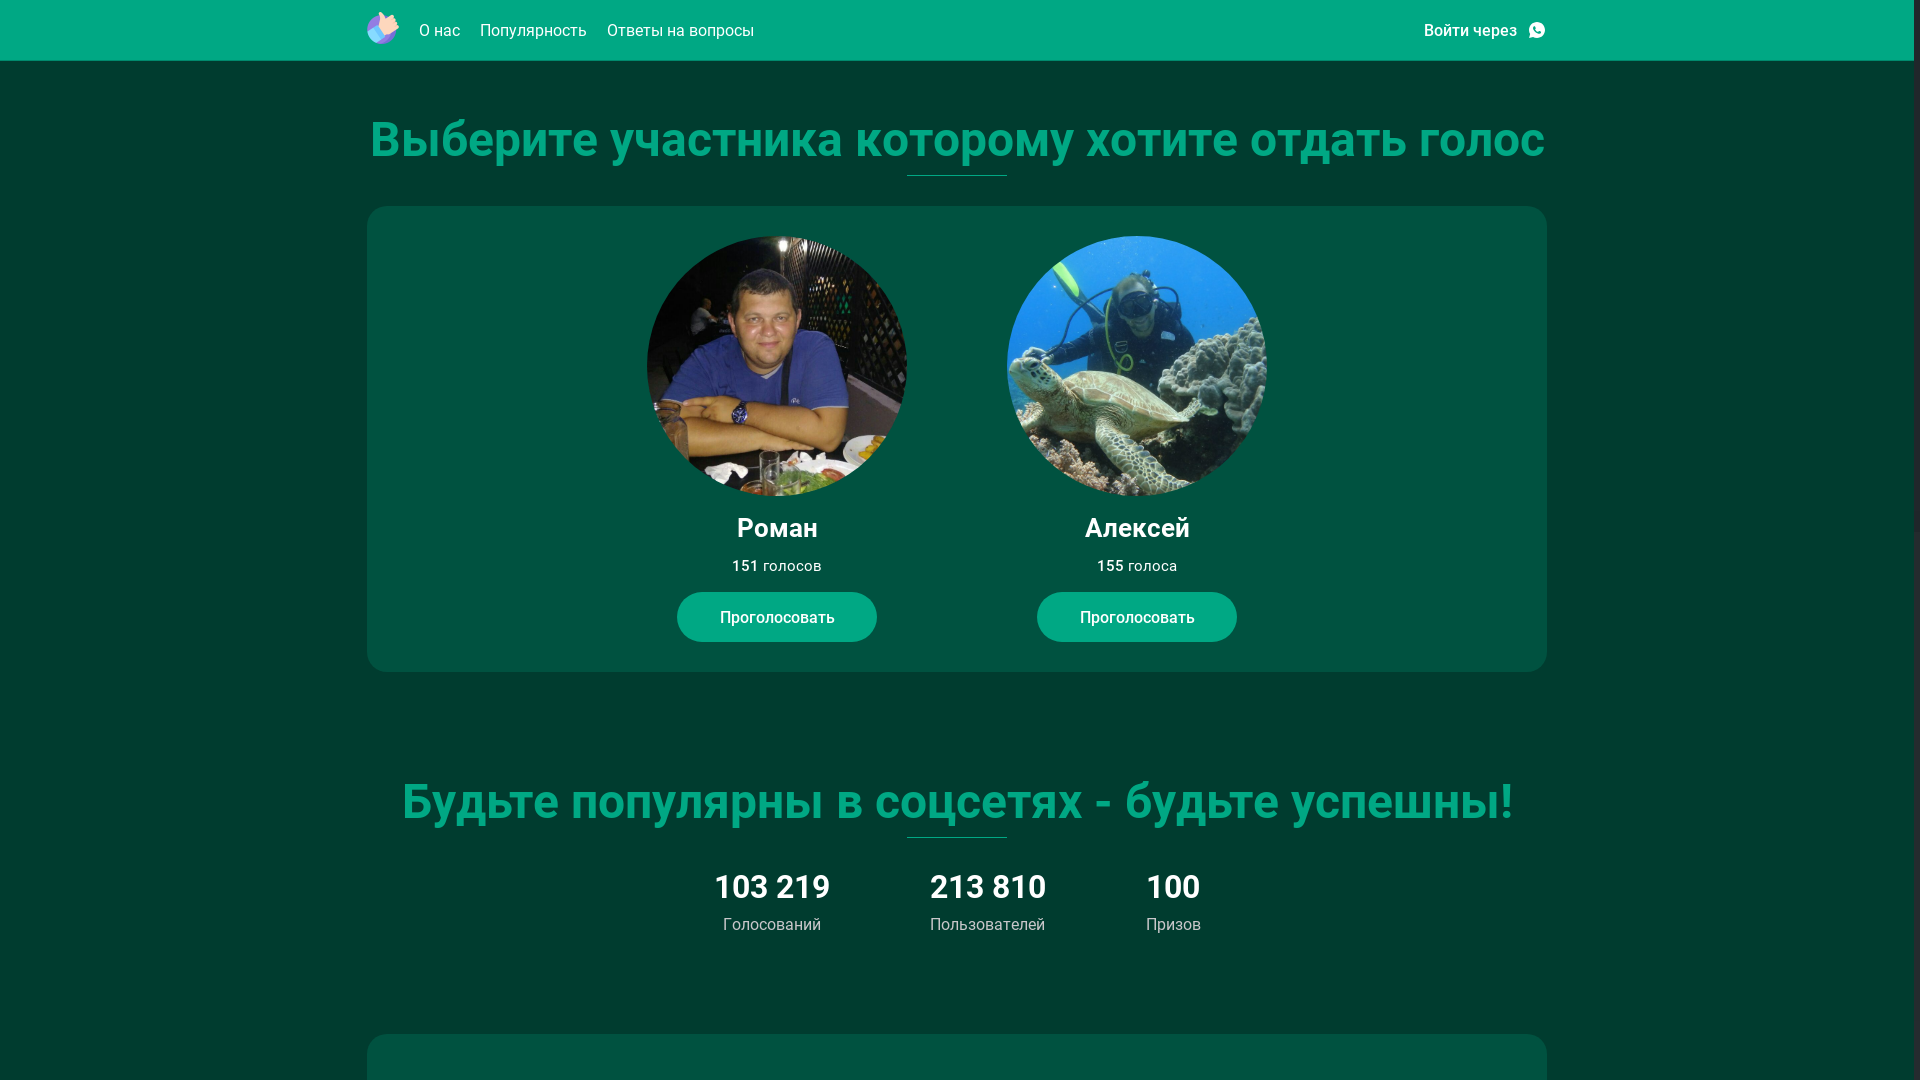

кластеры/голосование/000059.png --> нет вывода


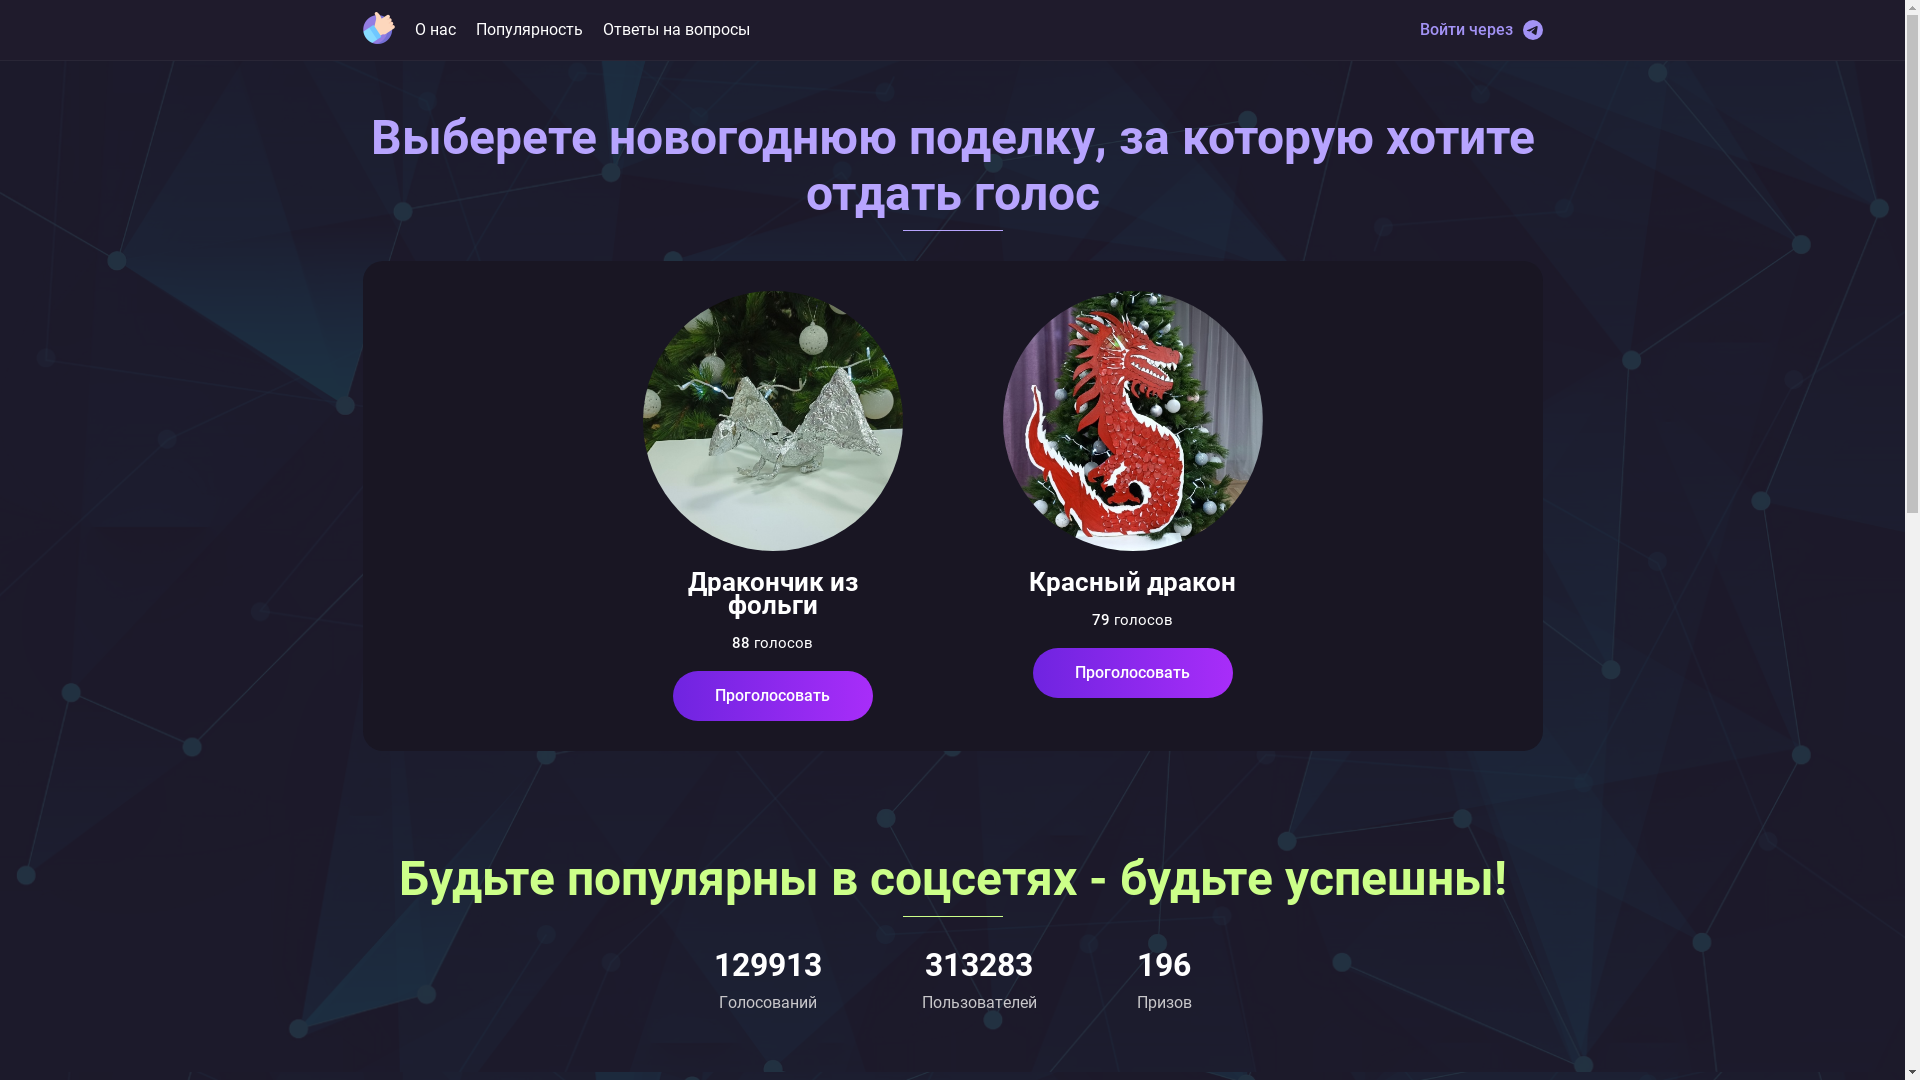

кластеры/голосование/000092.png --> нет вывода


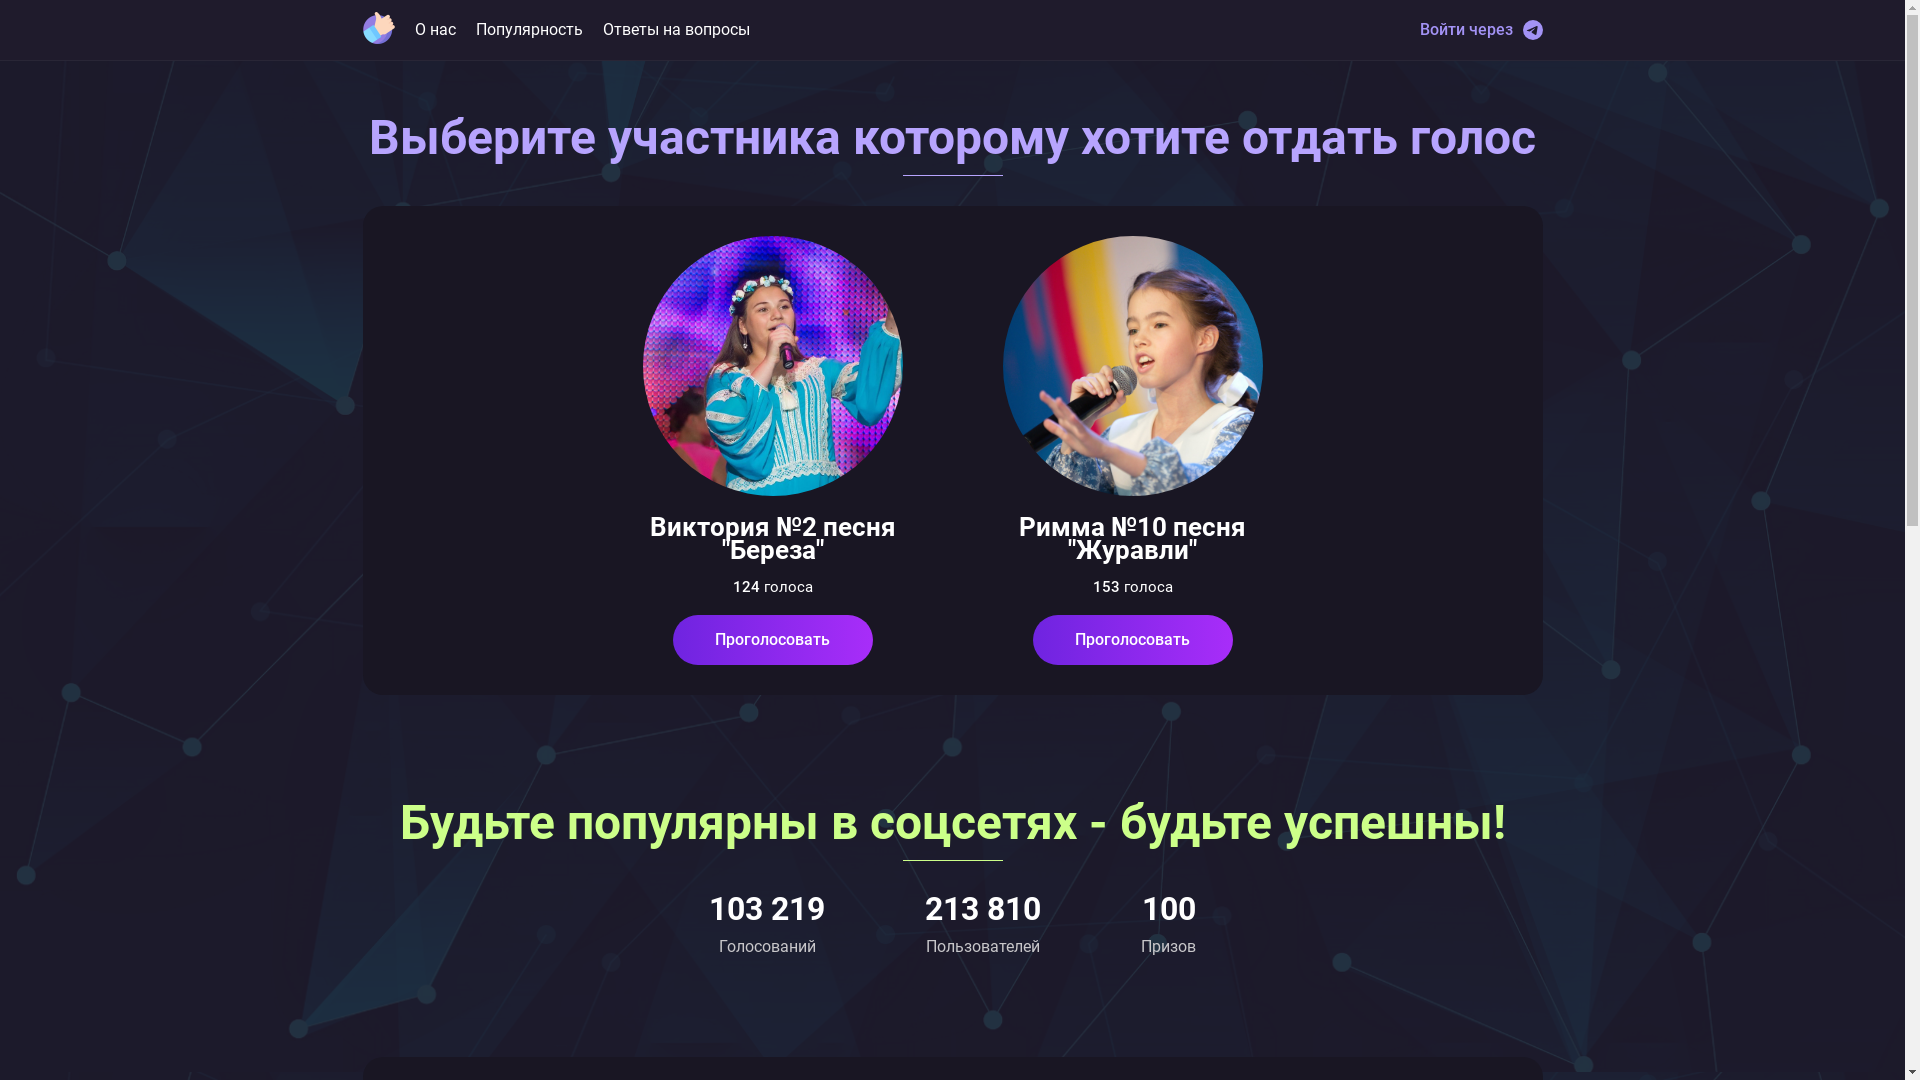

кластеры/голосование/000863.png --> нет вывода


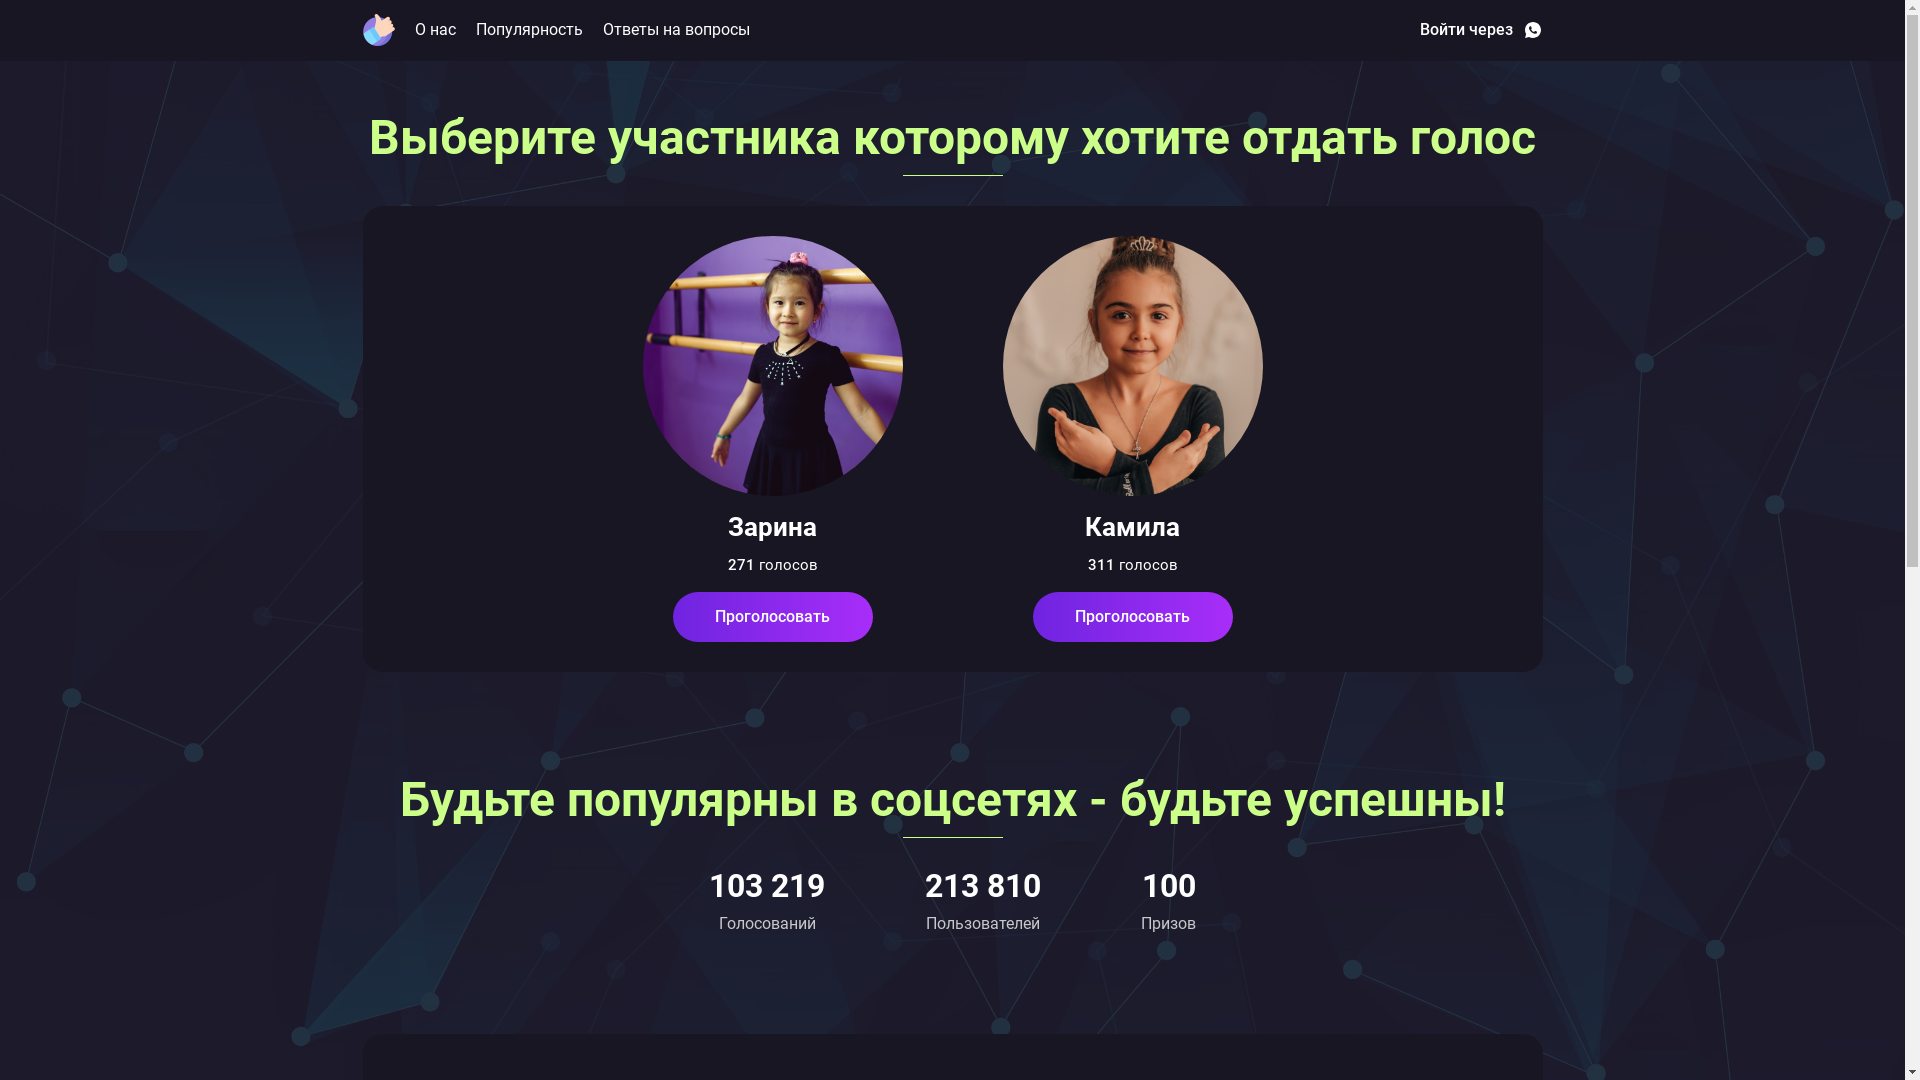

кластеры/голосование/000008.png --> нет вывода


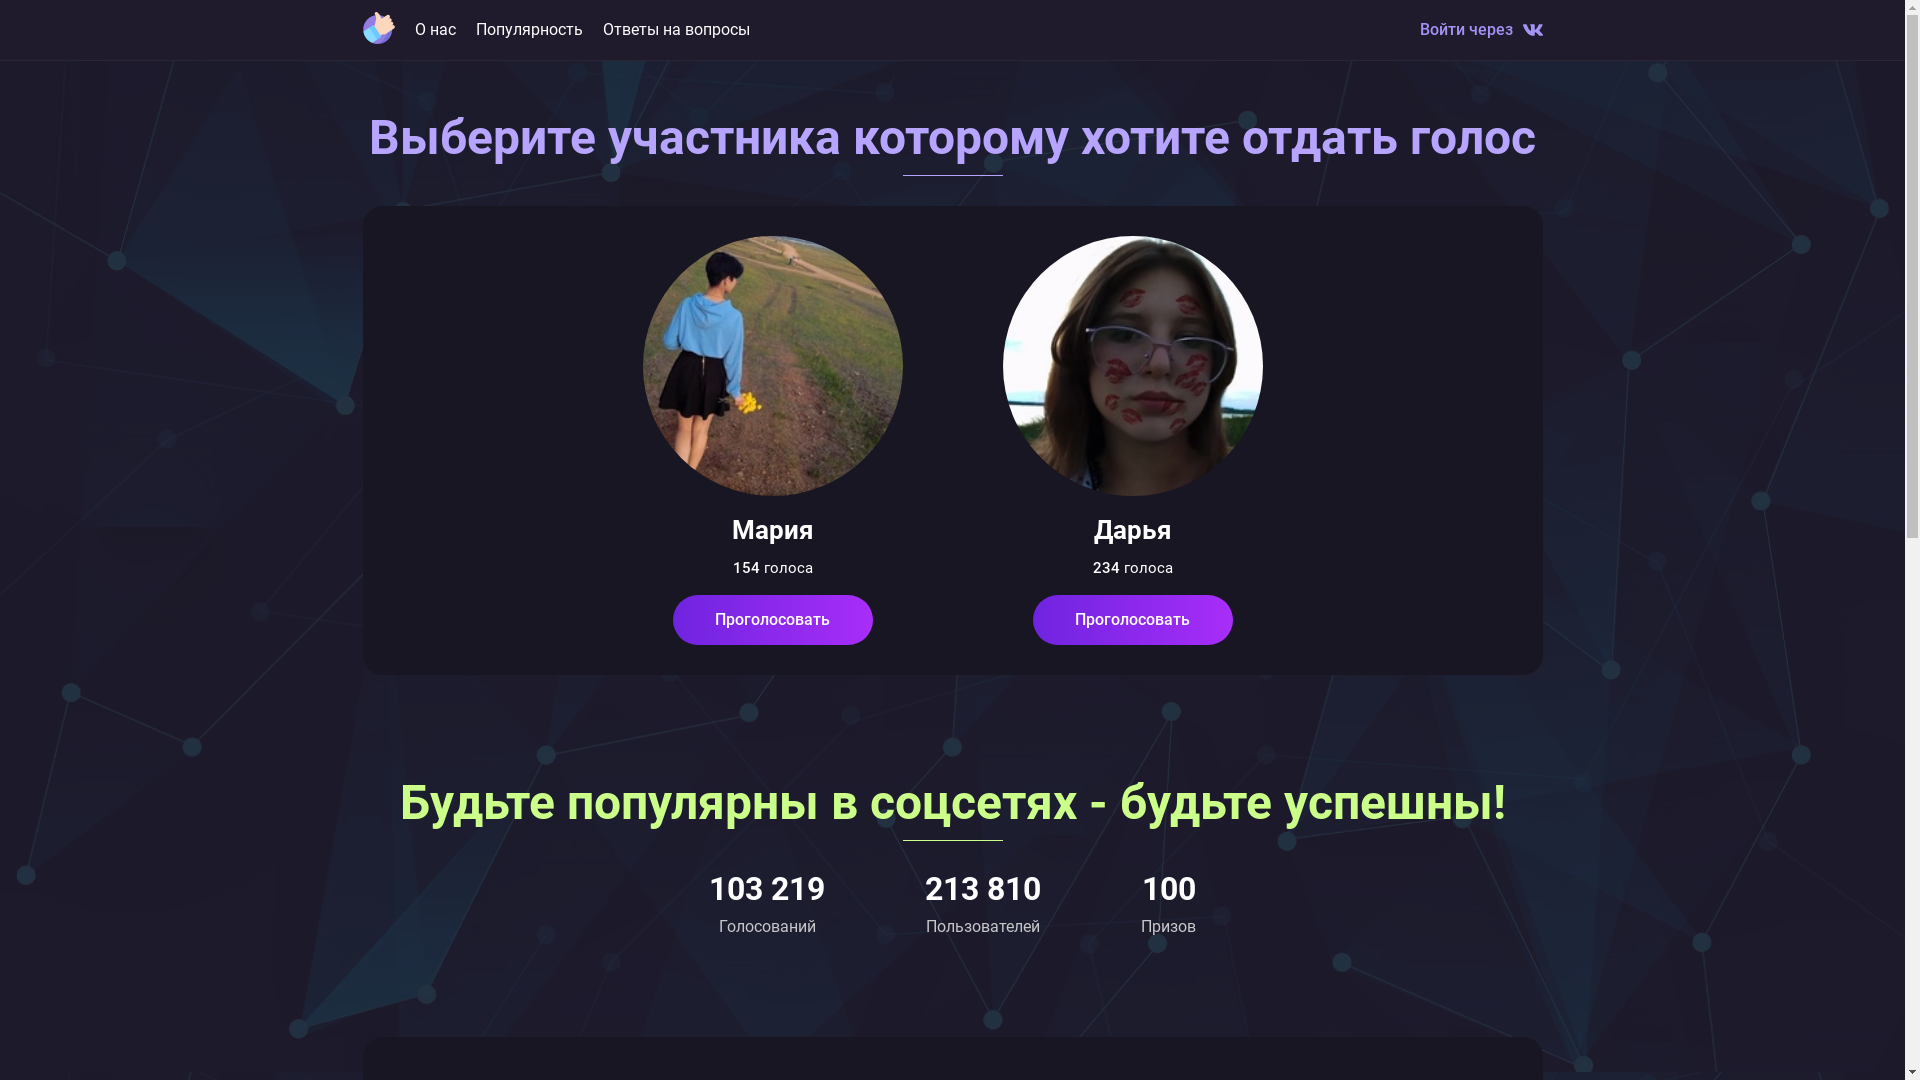

кластеры/голосование/000197.png --> нет вывода


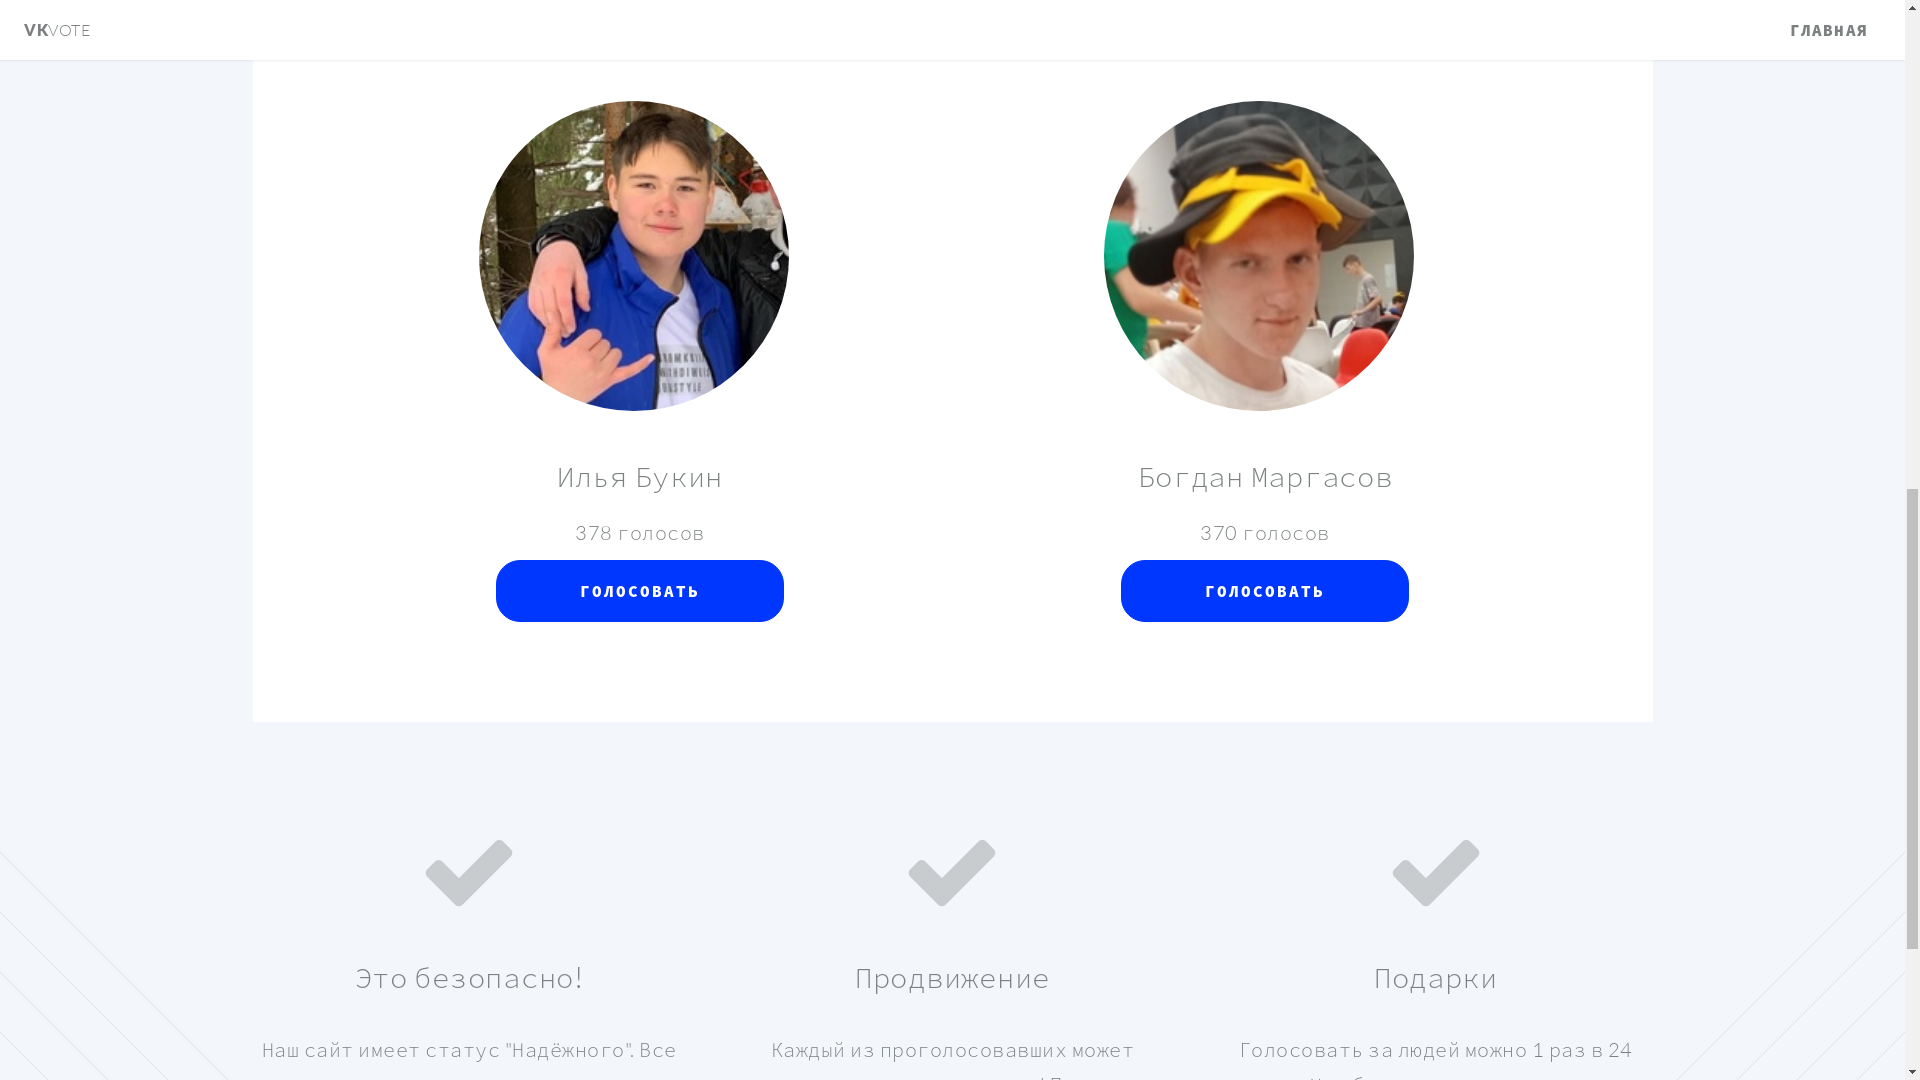

кластеры/голосование/000143.png --> нет вывода


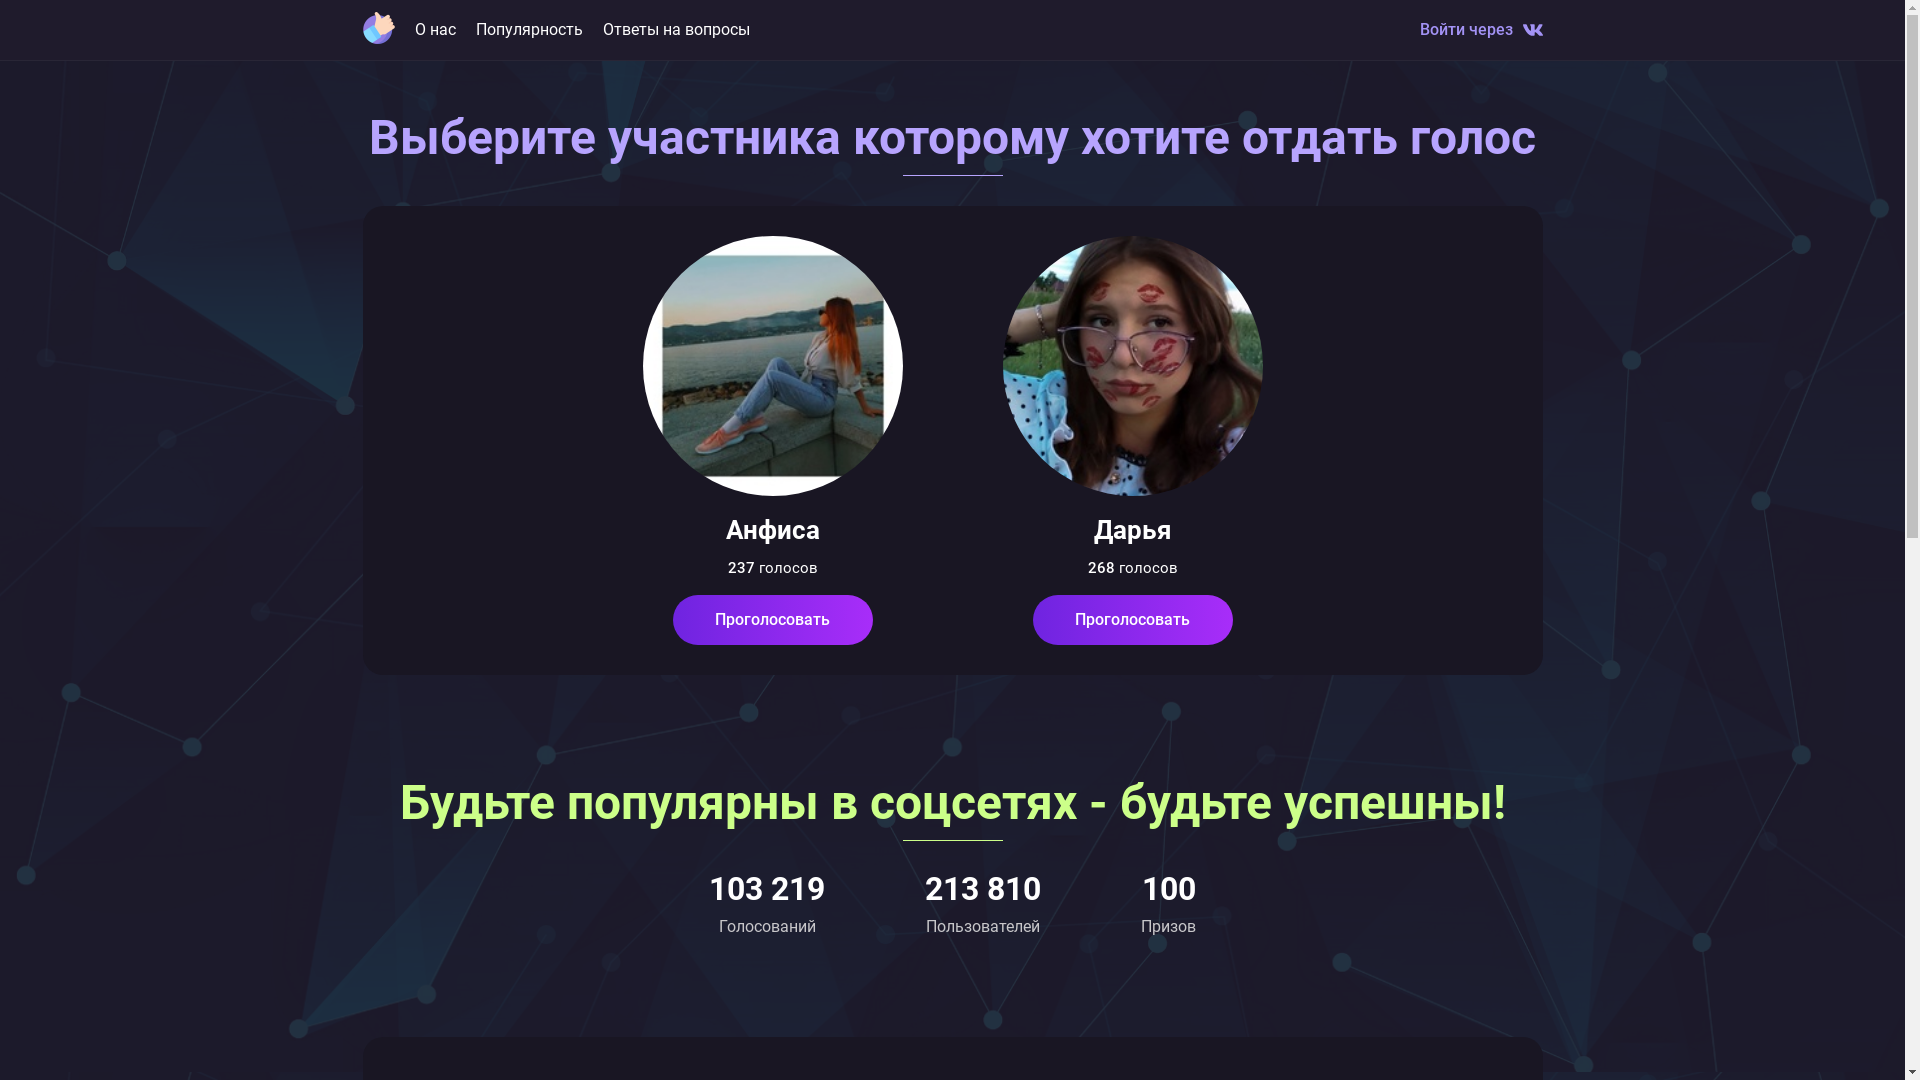

In [15]:
from IPython.display import display, Image as IPyImage

for path, output in results.items():
    print(f"{path} --> {output}")
    display(IPyImage(filename=path))

In [ ]:
prompt = '''
Есть такие кластеры: голосование, логинка, инвестиции, лотерея. Кластер может быть только один!

Если на картинке есть реклама, на которую нанесено изображение с излишкой денег или реклама содержит изображение с излишкой денег, а также изображение человека, который держит в руках большую сумму денег, то это лотерея.
Если на картинке есть реклама, на которую нанесено изображение скупателя, который показывает большое количество денег или среди рекламы, на которую ссылается баннер, также есть реклама, которая показывает большую сумму денег, то это лотерея.

Выведи для каждой картинки кластер.
'''

In [ ]:
import os
from collections import defaultdict
import glob

uploaded = {}
for path in glob.glob("кластеры/лотерея/*.png"):
    uploaded[path] = None

results = {}
labels = ['логинка', 'инвестиции', 'лотерея', 'голосование']
y_true = []
y_pred = []

class_stats = defaultdict(lambda: {"correct": 0, "total": 0})

for image_path in uploaded.keys():
    print(f"Обрабатывается: {image_path}")

    !python3 -m llava.eval.run_llava \
      --model-path liuhaotian/llava-v1.5-7b \
      --image-file "$image_path" \
      --query "$prompt" \
      --temperature 0.7 \
      --top_p 1.0 \
      --num_beams 1 \
      --max_new_tokens 100


    with open("temp_output.txt", "r") as f:
        lines = f.readlines()
        if lines:
            last_line = lines[-1].strip()
            results[image_path] = last_line
        else:
            last_line = "нет вывода"
            results[image_path] = last_line

    true_label = os.path.basename(os.path.dirname(image_path))
    y_true.append(true_label)

    predicted_label = None
    for label in labels:
        if label in last_line.lower():
            predicted_label = label
            break
    if predicted_label is None:
        predicted_label = "неизвестно"
    y_pred.append(predicted_label)

    class_stats[true_label]["total"] += 1
    if predicted_label == true_label:
        class_stats[true_label]["correct"] += 1

correct = sum(1 for t, p in zip(y_true, y_pred) if t == p)
total = len(y_true)
accuracy = correct / total if total > 0 else 0

print("\nAccuracy по классу 'лотерея':")
loginka_stats = class_stats["лотерея"]
if loginka_stats["total"] > 0:
    acc = loginka_stats["correct"] / loginka_stats["total"]
    print(f"лотерея: {acc:.2%} ({loginka_stats['correct']}/{loginka_stats['total']})")
else:
    print("лотерея: нет изображений")

print("\nОшибки (true → pred):")
for i in range(len(y_true)):
    if y_true[i] != y_pred[i]:
        image_name = list(results.keys())[i]
        print(f"{y_true[i]} --> {y_pred[i]} | {image_name} | output: {results[image_name]}")

In [ ]:
from IPython.display import display, Image as IPyImage

for path, output in results.items():
    print(f"{path} --> {output}")
    display(IPyImage(filename=path))

In [ ]:
prompt = '''
Есть такие кластеры: голосование, логинка, инвестиции, лотерея. Кластер может быть только один!

Если на картинке экран, на котором находится веб-страница со вкладкой, где можно зарегистрироваться и подписаться на Twitter или вкладка содержит информацию о Twitter-аккаунте и ссылку на страницу регистрации, то это логинка.
Если на картинке экран, на котором отображается снимок смартфона, снимок содержит QR-код, который можно прочитать с помощью смартфона или на экране есть кнопка, предлагающая "логин в телеграм", и еще одна кнопка, которая ведет на страницу с телеграм-чатами, то это логинка.
Если на картинке экран с кнопкой "Log in with Facebook" (Вход с Facebook), то это логинка.
Если на картинке экран, на котором отображается веб-страница социальной сети, на странице присутствует кнопка "Поделиться", и рядом с ней находится значок, который может быть использован для подключения к социальной сети, то это логинка.
Если на картинке экран, на котором находится веб-страница со вкладкой, где можно вписать свой логин и пароль или вкладка содержит кнопку "Sign in with Facebook", то это логинка.
Если на картинке экран, на котором отображается веб-страница со вкладкой, где можно вписать сообщение, вкладка содержит кнопку "Отправить", внизу страницы находится значок "Твиттер", также на странице есть кнопка "Вход", то это логинка.
Если на картинке экран, на котором отображается веб-страница, в правом нижнем углу экрана находится кнопка "Поделиться", а в верхней части экрана находится значок вставки изображения, то это логинка.
Если на картинке экран, на котором отображается веб-страница социальной сети Facebook, на странице присутствует кнопка "Авторизация", которая ведет на страницу входа в Facebook, также на странице присутствует значок "Поделитесь", то это логинка.
Если на картинке экран, на котором открывается веб-страница, на которой присутствует форма для заполнения, и в ней есть кнопка "Заполнить", то это логинка.
Если на картинке экран, на котором отображается вкладка для подключения к Instagram, вкладка содержит информацию о подключении и профиле пользователя, то это логинка.
Если на картинке заголовок, который говорит о QR-коде или на экране отображается QR-код, который можно прочитать с помощью смартфона или другого устройства, то это логинка.
Если на картинке экран компьютера, на котором открывается веб-страница, в центре экрана находится сообщение, которое может быть отправлено через электронную почту, также на экране можно увидеть кнопку, которая может быть нажата для отправки сообщения, то это логинка.
Если на странице присутствует кнопка "Sign Up", то это логинка.
Если на картинке экран, на котором отображается вкладка в социальной сети Instagram, вкладка содержит информацию о том, что пользователь пригласил кого-то в социальную сеть Instagram, то это логинка.

Выведи для каждой картинки кластер.
'''

In [ ]:
import os
from collections import defaultdict
import glob

uploaded = {}
for path in glob.glob("кластеры/логинка/*.png"):
    uploaded[path] = None

results = {}
labels = ['логинка', 'инвестиции', 'лотерея', 'голосование']
y_true = []
y_pred = []

class_stats = defaultdict(lambda: {"correct": 0, "total": 0})

for image_path in uploaded.keys():
    print(f"Обрабатывается: {image_path}")

    !python3 -m llava.eval.run_llava \
      --model-path liuhaotian/llava-v1.5-7b \
      --image-file "$image_path" \
      --query "$prompt" \
      --temperature 0.7 \
      --top_p 1.0 \
      --num_beams 1 \
      --max_new_tokens 100


    with open("temp_output.txt", "r") as f:
        lines = f.readlines()
        if lines:
            last_line = lines[-1].strip()
            results[image_path] = last_line
        else:
            last_line = "нет вывода"
            results[image_path] = last_line

    true_label = os.path.basename(os.path.dirname(image_path))
    y_true.append(true_label)

    predicted_label = None
    for label in labels:
        if label in last_line.lower():
            predicted_label = label
            break
    if predicted_label is None:
        predicted_label = "неизвестно"
    y_pred.append(predicted_label)

    class_stats[true_label]["total"] += 1
    if predicted_label == true_label:
        class_stats[true_label]["correct"] += 1

correct = sum(1 for t, p in zip(y_true, y_pred) if t == p)
total = len(y_true)
accuracy = correct / total if total > 0 else 0

print("\nAccuracy по классу 'логинка':")
loginka_stats = class_stats["логинка"]
if loginka_stats["total"] > 0:
    acc = loginka_stats["correct"] / loginka_stats["total"]
    print(f"логинка: {acc:.2%} ({loginka_stats['correct']}/{loginka_stats['total']})")
else:
    print("логинка: нет изображений")

print("\nОшибки (true → pred):")
for i in range(len(y_true)):
    if y_true[i] != y_pred[i]:
        image_name = list(results.keys())[i]
        print(f"{y_true[i]} --> {y_pred[i]} | {image_name} | output: {results[image_name]}")

In [ ]:
from IPython.display import display, Image as IPyImage

for path, output in results.items():
    print(f"{path} --> {output}")
    display(IPyImage(filename=path))

In [ ]:
prompt = '''
Есть такие кластеры: голосование, логинка, инвестиции, лотерея. Кластер может быть только один!

Если на картинке присутствуют несколько объектов, которые могут быть связаны с мероприятием, такие как флаги и смотровые площадки, то это инвестиции.
Если на картинке смартфон, на котором открыта страница с заказом на 300 000 рублей, также на странице присутствуют несколько банкнот, которые окружают смартфон, то это инвестиции.
Если на картинке несколько фотографий, которые представляют различные здания и их интерьеры, то это инвестиции.
Если на картинке рука, которая держит смартфон, на котором выводится информация на русском языке, или на экране присутствует сообщение, которое может быть связано с валютой или смартфонной приложением, то это инвестиции.
Если на картинке реклама, которая показывает фото мужчины в одежде, сидящего на фоне синего и белого барьера, или реклама содержит информацию о телеграм-инвестициях и содержит кнопку "Начать инвестирование" в правом нижнем углу, то это инвестиции.
Если на картинке сцена с несколькими нефтяными скважинами, которые выходят на поверхность, нефтяные скважины расположены в разных частях картинки, и некоторые из них выходят на поверхность, а другие нет, также на картинке есть несколько труб, которые могут быть связаны с нефтяными скважинами, то это инвестиции.
Если на картинке страница из интернета, на которой отображается логотип Tesla, а также фотографии и информация о Tesla Model X, то это инвестиции.
Если на картинке скриншот из интернета, на котором представлена информация о Gazprombank, то это инвестиции.
Если на картинке изображены два человека, которые стоят вместе и смотрят на камеру, они находятся перед экраном, на котором видно лого Soca, то это инвестиции.
Если на картинке веб-страницу, на которой находится кнопка "Заполнить форму" или кнопка для заполнения формы, то это инвестиции.
Если на картинке рекламное объявление на русском языке, которое рекламирует кредиты в иностранной валюте, или реклама содержит изображение смартфона, на котором видно, что пользователь получает кредит в размере 3000 евро, а также на рекламе присутствует изображение смартфона и ключа, которые могут быть связаны с кредитным продуктом, то это инвестиции.
Если на картинке есть реклама, которая предлагает инвестирование в телеграм-инвестирование, и она содержит информацию о том, что можно получить доход от этого инвестирования, то это инвестиции.
Если на картинке экран, на котором отображается информация о банковском счете, экран содержит текстовые данные, которые могут быть связаны с информацией о счете, таких как сроки, баланс и другие финансовые данные, то это инвестиции.
Если на картинке представлена оформленная веб-страница банка, на которой можно заполнить форму и получить кредит, или страница содержит информацию о банке и его услугах, или на странице можно увидеть несколько вариантов кредитов, которые можно получить, то это инвестиции.
Если на картинке экран с информацией, который, вероятно, является частью банковской программы, или на экране присутствуют несколько сообщений, которые могут быть связаны с банковской сетью или другими финансовыми услугами, то это инвестиции.
Если на картинке ночное изображение спутниковых снимков, которые показывают большой торговый центр в России, или в центре снимка находится крупный банковский комплекс, а вокруг него много машин, включая различные транспортные средства, такие как машины, которые движутся по дорогам и стоят на стоянках, то это инвестиции.
Если на картинке реклама, которая показывает смартфоны и мобильное приложение, смартфоны расположены на верхней части картинки, а мобильное приложение находится на нижней части, также на картинке можно увидеть несколько счетов, которые могут быть связаны с приложением или смартфонами, то это инвестиции.
Если на картинке реклама, которая показывает смартфон и его приложение, смартфон находится в центре, а приложение, вероятно, представляет собой кредитное приложение, реклама также содержит текстовые сообщения на нескольких языках, включая русский, украинский и английский, то это инвестиции.
Если на картинке рекламный плакат, на котором изображены огни и здания, также на плакате присутствует логотип "Farombank", то это инвестиции.
Если на картинке реклама, которая объявляет о возможности инвестирования в телеграм-инвестиции, и на странице указаны дополнительные ссылки, то это инвестиции.
Если на картинке страница веб-сайта Tesla, где можно увидеть информацию о машинах и продавцахЮ на странице также есть изображение машины Tesla, то это инвестиции.
Если на картинке рекламная бумага на русском языке, которая рекламирует кредиты в банке, реклама содержит информацию о кредитах и их преимуществах, а также показывает смартфон, который может быть использован для получения кредита, то это инвестиции.
Если на картинке страница веб-сайта, на которой изображены два разных изображения, одно изображение является фотографией Теслы, а другое - изображением человека, который стоит на фоне красного круга, или страница веб-сайта имеет название "teslax.ru" и предлагает 4000 рублей скидку на покупку, то это инвестиции.
Если на картинке банковская страница на русском языке, где указаны различные банковские услуги, то это инвестиции.
Если на картинке экран с текстом на русском языке, который может быть связан с финансовыми данными или другим контекстом, то это инвестиции.
Если на картинке рекламная доска, на которой отображается банковская ссылка, ссылка ведет на сайт, где можно получить доступ к различным банковским услугам, то это инвестиции.
Если на картинке экраны с информацией на русском языке, которые показывают финансовые данные, такие как курсы валюты и другие экономические показатели, то это инвестиции.
Если на картинке реклама, которая предлагает инвестирование в телеграм-многомерные активированные счета (Telegram ICO) и указывает на возможность получения прибыли в размере 4000 долларов США, то это инвестиции.
Если на картинке объявление на русском языке, которое содержит информацию о 4000 евро, на экране также присутствует кнопка, на которую можно нажать, чтобы получить дополнительную информацию, то это инвестиции.

Выведи для каждой картинки кластер.
'''

In [ ]:
import os
from collections import defaultdict
import glob

uploaded = {}
for path in glob.glob("кластеры/инвестиции/*.png"):
    uploaded[path] = None

results = {}
labels = ['логинка', 'инвестиции', 'лотерея', 'голосование']
y_true = []
y_pred = []

class_stats = defaultdict(lambda: {"correct": 0, "total": 0})

for image_path in uploaded.keys():
    print(f"Обрабатывается: {image_path}")

    !python3 -m llava.eval.run_llava \
      --model-path liuhaotian/llava-v1.5-7b \
      --image-file "$image_path" \
      --query "$prompt" \
      --temperature 0.7 \
      --top_p 1.0 \
      --num_beams 1 \
      --max_new_tokens 100


    with open("temp_output.txt", "r") as f:
        lines = f.readlines()
        if lines:
            last_line = lines[-1].strip()
            results[image_path] = last_line
        else:
            last_line = "нет вывода"
            results[image_path] = last_line

    true_label = os.path.basename(os.path.dirname(image_path))
    y_true.append(true_label)

    predicted_label = None
    for label in labels:
        if label in last_line.lower():
            predicted_label = label
            break
    if predicted_label is None:
        predicted_label = "неизвестно"
    y_pred.append(predicted_label)

    class_stats[true_label]["total"] += 1
    if predicted_label == true_label:
        class_stats[true_label]["correct"] += 1

correct = sum(1 for t, p in zip(y_true, y_pred) if t == p)
total = len(y_true)
accuracy = correct / total if total > 0 else 0

print("\nAccuracy по классу 'инвестиции':")
loginka_stats = class_stats["инвестиции"]
if loginka_stats["total"] > 0:
    acc = loginka_stats["correct"] / loginka_stats["total"]
    print(f"инвестиции: {acc:.2%} ({loginka_stats['correct']}/{loginka_stats['total']})")
else:
    print("инвестиции: нет изображений")

print("\nОшибки (true → pred):")
for i in range(len(y_true)):
    if y_true[i] != y_pred[i]:
        image_name = list(results.keys())[i]
        print(f"{y_true[i]} --> {y_pred[i]} | {image_name} | output: {results[image_name]}")

In [ ]:
from IPython.display import display, Image as IPyImage

for path, output in results.items():
    print(f"{path} --> {output}")
    display(IPyImage(filename=path))